# Imports and Utils

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import re
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
basepath = "/content/drive/MyDrive/DataMining22Gruppo8/data/dataset"

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 875 kB 5.0 MB/s 


#Visualization functions

In [ ]:
def visualize(data=None, x=None, y=None, xlabel=None, ylabel=None, title=None, plot_type="plot", ax=None, **kwargs):
  plts = ['plot', 'hist', 'scatter', 'boxplot', 'barplot']
  if plot_type not in plts:
      raise ValueError("Invalid plot type. Expected one of: %s" % plts)
  
  if(plot_type == "scatter"):
    sns.scatterplot(data=data, x=x, y=y, ax=ax, **kwargs)
  elif(plot_type == "plot"):
    sns.lineplot(data=data, x=x, y=y, ax=ax, **kwargs)
  elif(plot_type == "hist"):
    sns.histplot(data=data, x=x, y=y, ax=ax, **kwargs)
  elif(plot_type == "boxplot"):
    sns.boxplot(data=data, x=x, y=y, ax=ax, **kwargs)
  elif(plot_type == "barplot"):
    sns.barplot(data=data, x=x, y=y, ax=ax, **kwargs)

  plt.xlabel(xlabel, fontsize=14)
  plt.ylabel(ylabel, fontsize=14)
  plt.title(title, fontsize=16)
  plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
class Correlation():
  def __init__(self,df):
    self.df = df

  def compute(self,frac):
    self.mx = self.df.sample(frac=frac).corr()
  
  def heatmap(self, dim):
    fig, ax = plt.subplots(figsize=(dim, dim))
    im = ax.imshow(self.mx)
    im.set_clim(-1,1)
    fig.colorbar(im, orientation='vertical', fraction = 0.05)

    # Show and rotate ticks
    plt.xticks(np.arange(len(self.mx.columns)),self.mx.columns, rotation=90, fontsize=15)
    plt.yticks(np.arange(len(self.mx.index)),self.mx.index, rotation=0, fontsize=15)

    # Add numerical values
    for i in range(len(self.mx.columns)):
        for j in range(len(self.mx.index)):
            text = ax.text(j, i, round(self.mx.to_numpy()[i, j], 1),
                          ha="center", va="center", color="black")

    plt.show()


In [ ]:
from itertools import combinations

def cluster_plots(df): 
  plots = list(combinations([key for key in df.keys()], 2))
  
  for x,y in plots:
    plt.figure(figsize=(9,6))
    visualize(x=df[x][dbscan.labels_ != -1], y=df[y][dbscan.labels_ != -1], 
            plot_type='scatter', c=dbscan.labels_[dbscan.labels_ != -1], xlabel=x, ylabel=y,
            title="{} over {}".format(x, y)) 
    plt.show

# 1 Data understanding and preparation

## 1.0 Data Loading

In [ ]:
#!ls /content/drive/MyDrive/DataMining22Gruppo8/data/dataset.zip
#!ls /content/drive/MyDrive/DataMining22Gruppo8/data/dataset
#unzip a fresh dataset!
#!unzip -x dataset.zip
#!ls /content/drive/MyDrive/DataMining22Gruppo8/data/dataset

In [ ]:
users_path = basepath+"/users.csv"
tweet_path = basepath+"/tweets.csv"

In [ ]:
raw_users = pd.read_csv(users_path)

In [ ]:
raw_tweets = pd.read_csv(tweet_path)

NameError: ignored

## 1.1 Analysis on users' dataset


###1.1.1 Dataset exploration and comprehension
We'll look through all the attributes for basic understanding 

In [ ]:
raw_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 539.6+ KB


The user dataset seems a lot cleaner than the tweets' one. As we can see we have just one username missing and some statuses_count: a lot better than what expected!

In [ ]:
len(raw_users) - len(raw_users.id.unique())

0

... also we have all unique IDs. So, for this very reason, we'll set ID as index of raw_users.

In [ ]:
raw_users.set_index('id', inplace=True)

In [ ]:
len(raw_users) - len(raw_users.name.unique())

147

... but we do not have all unique names. This does not seem like a huge problem as we suppose it is not mandatory to have a unique username.

In [ ]:
raw_users[raw_users.name.isnull()]

,name,lang,bot,created_at,statuses_count
id,,,,,
2166124159,NaN,en,0,2018-11-02 06:39:14,6566.0


... this is the only user that does not have a name. We can either (1) give him a random name or (2) drop the row. As we've just seen above, there is no need to drop the information (even though is minimal considering the dataset) because username does not need to be unique, so we'll just give him a name:

In [ ]:
raw_users.name.fillna('null_user', inplace=True)

In [ ]:
raw_users.lang.value_counts()

en                    9970
it                     906
es                     319
pt                      65
en-gb                   50
ru                      42
fr                      36
ja                      33
zh-tw                   17
tr                      14
id                      12
ko                       9
de                       8
nl                       6
en-GB                    4
ar                       3
zh-TW                    3
da                       2
Select Language...       2
en-AU                    1
zh-cn                    1
pl                       1
el                       1
fil                      1
sv                       1
xx-lc                    1
Name: lang, dtype: int64

... looking at languages we might see something wrong. Let's start by non-existent ISO codes, those being: fil and xx-lc. We also notice that 2 user are registered without selecting a language.

We do have same language categories spelled different (e.g., en-GB and en-gb); thus we want them to match.

One further consideration may be to actually comprehend all the similar languages (e.g., zh-tw and zh-cn) under their wider category (e.g., zh). This might be useful considering the fact sub-languages are in little presence amongst the wider ones.

In [ ]:
raw_users.lang.replace(['en-GB', 'en-gb', 'en-AU'], 'en', inplace=True)

In [ ]:
raw_users.lang.replace(['zh-tw', 'zh-TW', 'zh-cn'], 'zh', inplace=True)

In [ ]:
raw_users.lang.replace(['xx-lc', 'sv', 'Select Language...'], 'wrl', inplace=True)

... users' language are now better organized. We want to set non-existent languages with a temporary value ('wrl'), so that we can adjust it later on.

In [ ]:
raw_users.bot.unique()

array([1, 0])

...bot flags do not have any inconsistent value (just 0s and 1s)

In [ ]:
len(raw_users[raw_users.statuses_count.isnull()])

399

... we notice that we have 399 nan values for the statuses_count attribute (out of 11508). We won't drop them as we'll estimate these values later on the work.

### 1.1.2 Save and load checkpoint
We'll save the working dataset and use that from now on

In [ ]:
raw_users.to_csv(basepath + '/pp_users.csv')

In [ ]:
pp_users = pd.read_csv(basepath + '/pp_users.csv', index_col='id', parse_dates=['created_at'])

### 1.1.3 Data visualization and outliers handling
From now on, we are going to work with the variable pp_user, read from the csv checkpoint

In [ ]:
pp_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            11508 non-null  object 
 1   lang            11508 non-null  object 
 2   bot             11508 non-null  int64  
 3   created_at      11508 non-null  object 
 4   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 539.4+ KB


In [ ]:
pp_users.name.describe()

count     11508
unique    11361
top        Sara
freq          7
Name: name, dtype: object

In [ ]:
#the only way we could extract information from names is with embeddings/or NLP techniques that are way too processor heavy
# that are not the scope of this course, for this reason we drop the name column
pp_users.drop(columns=["name"],inplace=True)

Let's start looking at the attributes' distributions:

In [ ]:
pp_users['lang'].describe()

count     11508
unique       19
top          en
freq      10025
Name: lang, dtype: object

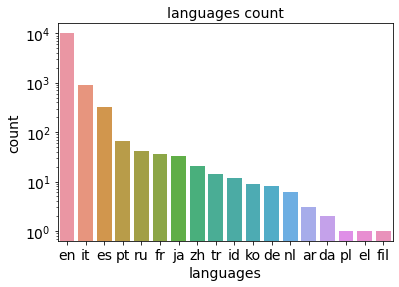

In [ ]:
visualize(x=pp_users.lang.value_counts().index, y=pp_users.lang.value_counts().values, 
          xlabel='languages', ylabel='count', title='languages count',
          plot_type="barplot")
plt.yscale("log")
plt.show()

In [ ]:
pp_users.lang.replace('wrl', pp_users.lang.mode()[0], inplace=True)

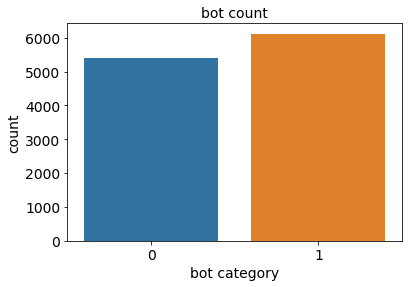

In [ ]:
visualize(x=pp_users.bot.value_counts().index, y=pp_users.bot.value_counts().values, 
          xlabel='bot category', ylabel='count', title='bot count',
          plot_type="barplot")
plt.show()

Now, looking at the created_at variable, we'll investigate through years: 

In [ ]:
pp_users.created_at.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   11508
unique                  11423
top       2017-06-25 15:33:05
freq                        5
first     2012-01-24 01:57:38
last      2020-04-21 07:28:31
Name: created_at, dtype: object

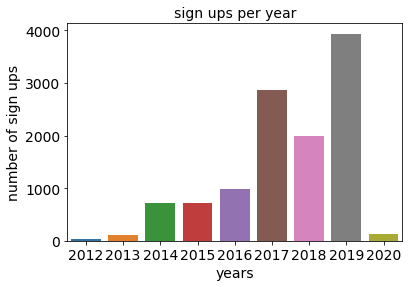

In [ ]:
visualize(x=pp_users.created_at.apply(lambda x: x.year).value_counts().index, 
          y=pp_users.created_at.apply(lambda x: x.year).value_counts().values,
          xlabel='years', ylabel='number of sign ups', title='sign ups per year',
          plot_type='barplot')
plt.show()

... the bar plot shown represent the distribution using years as the x scale. As we can see most users are registered between 2017 and 2019.

Let's zoom in:

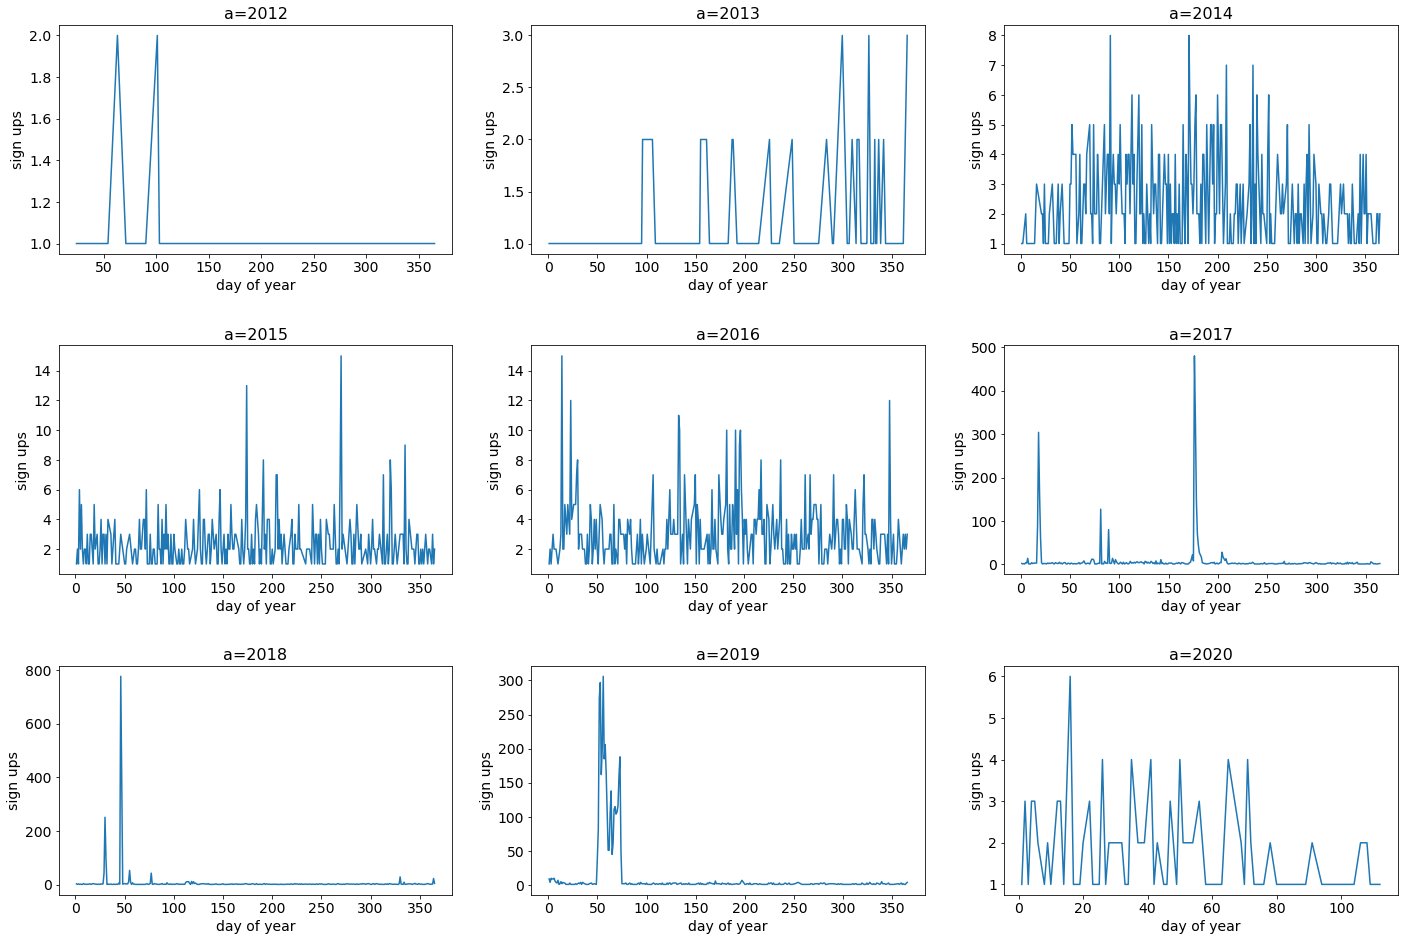

In [ ]:
all_years = pp_users.created_at.apply(lambda x: int(x.year))
all_days = pp_users.created_at.apply(lambda x: int(x.day_of_year))

grouped = pp_users.groupby(all_years)
rowlength = int(grouped.ngroups/3)
fig, axs = plt.subplots(figsize=(24,16), 
                        nrows=3, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
  group = grouped.get_group(key)
  days_of_year = group.created_at.apply(lambda x: int(x.day_of_year))
  
  visualize(ax=ax, data=days_of_year.value_counts().sort_index())
  ax.set_title('a=%d'%key, fontsize=16)
  ax.set_xlabel('day of year', fontsize=14)
  ax.set_ylabel('sign ups', fontsize=14)
  ax.tick_params(axis='both', which='major', labelsize=14)
    
  plt.subplots_adjust(hspace=0.5)
    
plt.show()

... as we can observe by the zoomed-in distributions, we have some weird peaks 
during some days of some years. (Also, we do not need this type of granular precision; we can actually look at months.)

It might be interesting to see how many "signed-up users" during those peaks were flagged as bots. Note that it is not necessary to consider every year listed, since most of them have a too low ratio of sign ups to actually be considered as "weird peak".

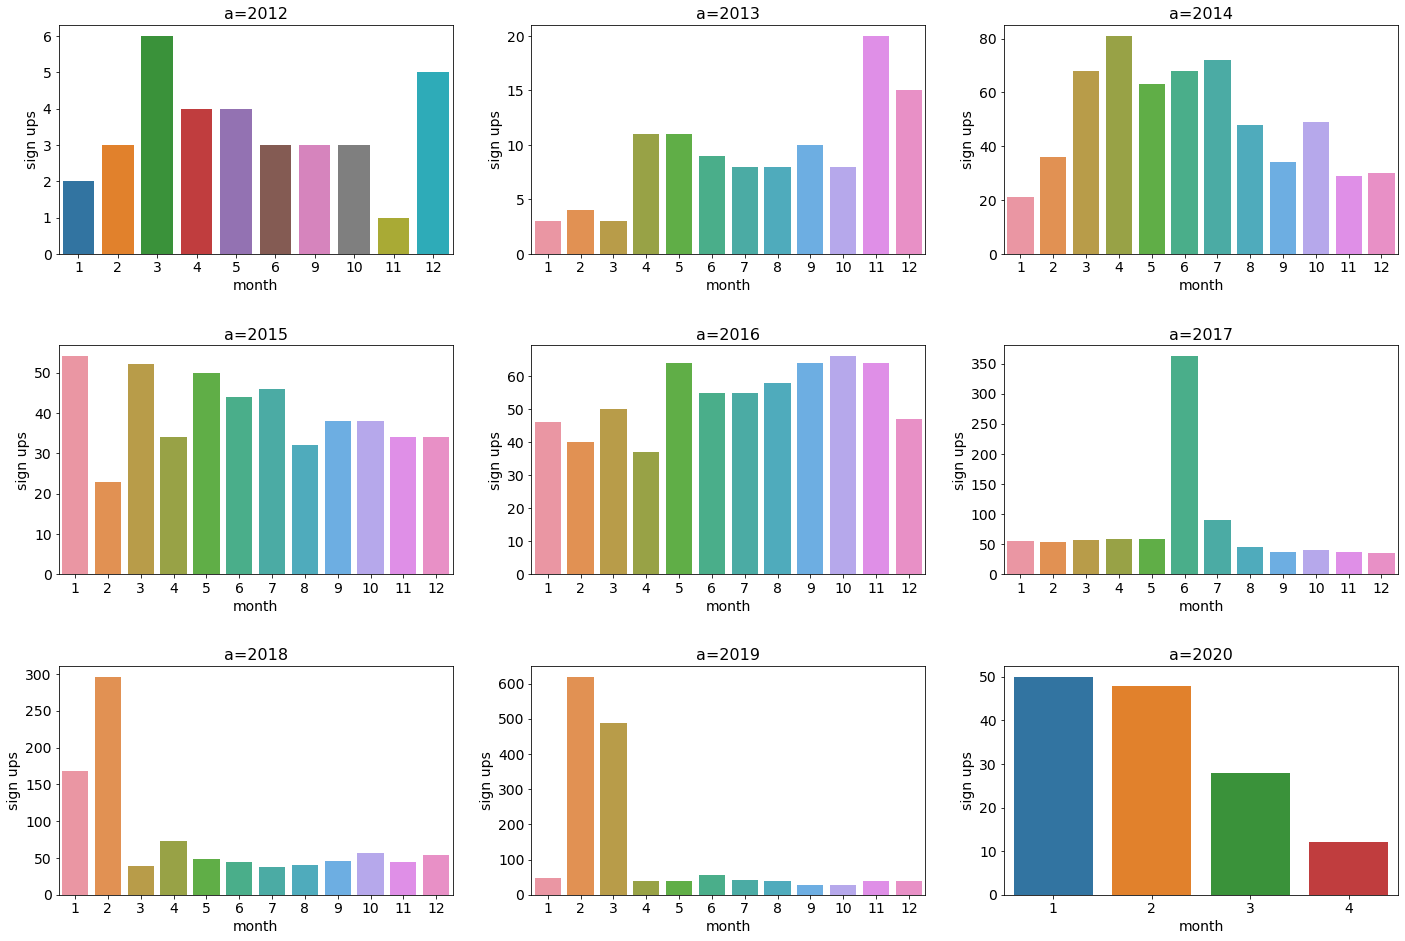

In [ ]:
all_years = pp_users.created_at.apply(lambda x: int(x.year))
all_months = pp_users.created_at.apply(lambda x: int(x.month))

grouped = pp_users.groupby(all_years)
rowlength = int(grouped.ngroups/3)
fig, axs = plt.subplots(figsize=(24,16), 
                        nrows=3, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
  group = grouped.get_group(key)
  usr_per_year = group[group['bot']==0]
  bot_per_year = group[group['bot']==1]
  usr_per_month = usr_per_year.created_at.apply(lambda x: int(x.month)).value_counts()
  bot_per_month = bot_per_year.created_at.apply(lambda x: int(x.month)).value_counts()
  
  if len(usr_per_month) != 0:
    # ax.bar(usr_per_month.sort_index().index-0.2, height=usr_per_month.sort_index().values, width=0.2, align='center', label='usr sign ups')
    sns.barplot(x=usr_per_month.sort_index().index, y=usr_per_month.sort_index().values, ax=ax)
  if len(bot_per_month) != 0:
    # ax.bar(bot_per_month.sort_index().index+0.2, height=bot_per_month.sort_index().values, width=0.2, align='center', label='bot sign ups')
    sns.barplot(x=usr_per_month.sort_index().index, y=usr_per_month.sort_index().values, ax=ax)
  
  ax.set_title('a=%d'%key, fontsize=16)
  ax.set_xlabel('month', fontsize=14)
  ax.set_ylabel('sign ups', fontsize=14)
  ax.tick_params(axis='both', which='major', labelsize=14)
    
  plt.subplots_adjust(hspace=0.5)  
plt.show()

... and, as we can notice, those peaks we identified before were actually bot's sign ups. That's good to know.

Now let's look at the statuses_count attribute, precisely, we'll get the sum of statuses made by users and bots, respectively:

In [ ]:
print('statuses count from users: ', pp_users[pp_users['bot']==0].statuses_count.sum())
print('statuses count from bots: ', pp_users[pp_users['bot']==1].statuses_count.sum())

statuses count from users:  58109628.0
statuses count from bots:  7248089.0


... the number of user statuses are 8x bigger than bot's one. 

Let's observe what languages do bot tend to select:

In [ ]:
bot_languages = pd.crosstab(pp_users['bot'], pp_users['lang'])
# bot_languages = bot_languages.div(bot_languages.sum(1).astype(float), axis=0) #if we want to see normalized data
bot_languages

lang,ar,da,de,el,en,es,fil,fr,id,it,ja,ko,nl,pl,pt,ru,tr,zh
bot,,,,,,,,,,,,,,,,,,
0,3,2,6,1,5055,182,1,23,9,0,31,3,5,1,28,15,7,20
1,0,0,2,0,4974,137,0,13,3,906,2,6,1,0,37,27,7,1


...as we might have imagined, the majority of bots have 'en' as selected language, consistently to the percentage of users' selected language. On the other hand, though, we should notice that there are no italian users; in fact, as we can see, 906 bots selected italian as main language (against 0 selections by human users).

Now it might be interesting to see if there's any kind of correlation between data. Though, we do not have much numerical information. Anyway, there may be some correlation between the 'created_at' variable and the 'statuses_count' one, given the fact that a user tend to be more active in longer periods of time. So, we might expect that older the user, bigger the statuses_count:

In [ ]:
#let's set a today date that will be equal for every calculation
today_date = pp_users.created_at.max().normalize()
#we'll get user lifespan in days
usr_lifespan = pp_users.created_at.apply(lambda x: today_date-x).dt.days
# usr_lifespan
usr_lifespan.corr(pp_users['statuses_count'])

0.28740135376472264

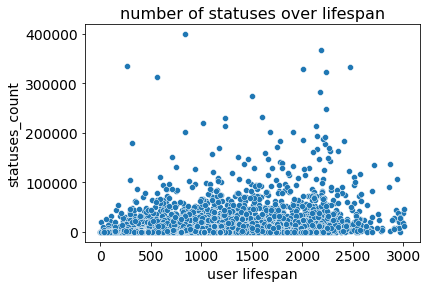

In [ ]:
visualize(x=usr_lifespan, y=pp_users.statuses_count, 
          xlabel='user lifespan', ylabel='statuses_count', title='number of statuses over lifespan', 
          plot_type='scatter')
plt.show()

Despite our expectations, there is little correlation between the two variables.
Let's see if it depends on bot's categorization:

infos about statuses count per category: users
size of the group:  5392
total statuses_count:  58109628.0
mean:  11638.21910674945
std:  26719.438432180214
median:  2041.0
mode:  0    43.0
dtype: float64
min:  0.0
max:  399555.0
correlation between statuses_count and lifespan:  0.26842041191678917


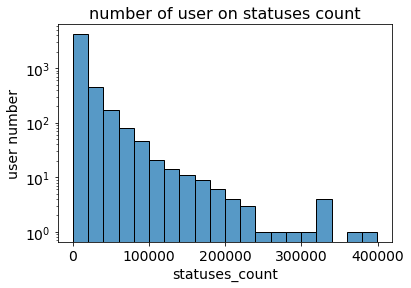

infos about statuses count per category: bots
size of the group:  6116
total statuses_count:  7248089.0
mean:  1185.1028449967298
std:  5373.5506300358375
median:  53.0
mode:  0    44.0
dtype: float64
min:  0.0
max:  214410.0
correlation between statuses_count and lifespan:  0.2562866280562958


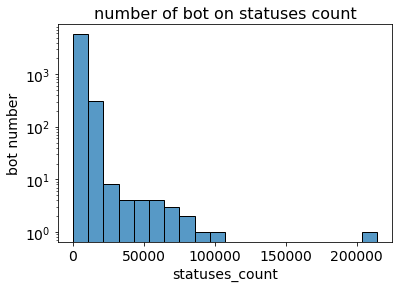

In [ ]:
for i in range (0, 2):
  g = pp_users.groupby('bot').get_group(i)
  print('infos about statuses count per category: {}'.format('users' if i==0 else 'bots'))
  print('size of the group: ', len(g))
  print('total statuses_count: ', g.statuses_count.sum())
  print('mean: ', g.statuses_count.mean())
  print('std: ', g.statuses_count.std())
  print('median: ', g.statuses_count.median())
  print('mode: ', g.statuses_count.mode())
  print('min: ', g.statuses_count.min())
  print('max: ', g.statuses_count.max())
  
  lifespan = g.created_at.apply(lambda x: today_date-x).dt.days
  print('correlation between statuses_count and lifespan: ', lifespan.corr(g['statuses_count']))
  
  visualize(data=g.statuses_count, plot_type='hist', bins=20,
            xlabel='statuses_count', ylabel='{} number'.format('user' if i==0 else 'bot'),
            title='number of {} on statuses count'.format('user' if i==0 else 'bot'))
  plt.yscale("log")
  plt.show()


users and bots do not differ so much from each other.

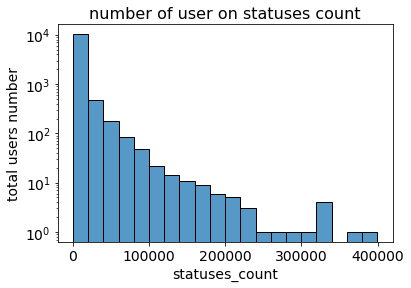

In [ ]:
visualize(data=pp_users.statuses_count, plot_type='hist', bins=20,
          xlabel='statuses_count', ylabel='total users number', 
          title='number of user on statuses count')
plt.yscale('log')
plt.show()

In [ ]:
pp_users.statuses_count.describe()

count     11109.000000
mean       5883.312359
std       19073.007305
min           0.000000
25%          41.000000
50%          68.000000
75%        2916.000000
max      399555.000000
Name: statuses_count, dtype: float64

Looking at the scatter, though, we can see there are some too high values for the statuses_count. Let's see them better in a boxplot:

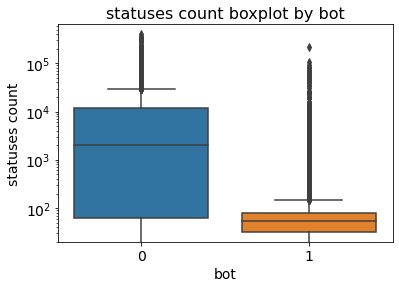

In [ ]:
visualize(x=pp_users.bot, y=pp_users.statuses_count, plot_type='boxplot',
          xlabel='bot', ylabel='statuses count', 
          title='statuses count boxplot by bot')

plt.yscale('log')
plt.show()

... looking at the boxplot we can see too many values outside the maximum limit, but they're not too big to be considered real outliers.

Note that pandas uses q(0.75) + 1.*iqr (where iqr is q(0.75) - q(0.25), as the maximum limit. This is a way too bigger range to be sure the points are real outliers.

In [ ]:
users = pp_users.groupby('bot').get_group(0)
iqr_users = users.statuses_count.quantile(0.75) - users.statuses_count.quantile(0.25)
maximum_users = users.statuses_count.quantile(0.75) + 1.5 * iqr_users
print('outliers per users using 1.5*iqr: ', len(users[users.statuses_count>maximum_users]))
print('outliers per users using 90th percentile: ', len(users[users.statuses_count>users.statuses_count.quantile(0.9)]))

outliers per users using 1.5*iqr:  554
outliers per users using 90th percentile:  500


In [ ]:
bots = pp_users.groupby('bot').get_group(1)
iqr_bots = bots.statuses_count.quantile(0.75) - bots.statuses_count.quantile(0.25)
maximum_bots = bots.statuses_count.quantile(0.75) + 1.5 * iqr_bots
print('outliers per bots using 1.5*iqr: ', len(bots[bots.statuses_count>maximum_bots]))
print('outliers per bots using 90th percentile: ', len(bots[bots.statuses_count>bots.statuses_count.quantile(0.9)]))

outliers per bots using 1.5*iqr:  1055
outliers per bots using 90th percentile:  612


In [ ]:
bots[bots.statuses_count>bots.statuses_count.quantile(0.9)]

,lang,bot,created_at,statuses_count
id,,,,
1273186980,en,1,2018-03-18 20:11:01,1179.0
243282862,en,1,2016-01-28 18:20:58,11735.0
531177445,en,1,2017-03-22 12:15:46,12395.0
220116356,en,1,2015-11-28 20:47:29,12569.0
1601378383,en,1,2018-07-19 16:39:41,1073.0
...,...,...,...,...
194770829,en,1,2015-09-26 23:28:51,11141.0
570575741,it,1,2017-05-06 06:04:59,4262.0
1372026204,en,1,2018-04-24 12:39:38,3139.0


... even looking at these rows, we cannot be sure any of them represents real outliers. In fact, it might be valid information we are looking at. For instance, 10.000 statuses in 3 years of activity might be legit (also considering we're looking at a bot profile).

We might need something more specific to decide whether or not they can be considered outliers. Let's create a function that'll tell us how many statuses per day every user has, and start focusing on it.

In [ ]:
statuses_per_day = pp_users.statuses_count/usr_lifespan

In [ ]:
pp_users['st_per_day'] = statuses_per_day

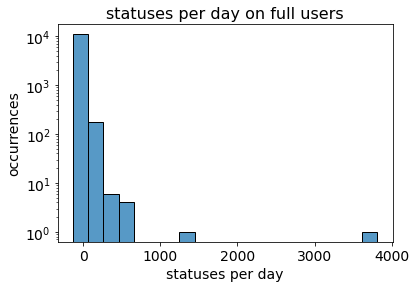

In [ ]:
visualize(data=statuses_per_day, plot_type='hist', bins=20,
          xlabel='statuses per day', ylabel='occurrences', 
          title='statuses per day on full users')

plt.yscale('log')
plt.show()

In [ ]:
statuses_per_day.max()

3812.2

... it' hard at this point, to be sure that these values actually represent outliers. Even though they might be high numbers (such as 282 post per day) it wouldn't be so out of context if a bot did behave like that. 
282 posts per day means posting every 5 minutes since the minute the user registered until the data crawling.

In [ ]:
users_lifespan = users.created_at.apply(lambda x: today_date-x).dt.days
bots_lifespan = bots.created_at.apply(lambda x: today_date-x).dt.days

In [ ]:
bots_statuses_per_day = bots.statuses_count/bots_lifespan
users_statuses_per_day = users.statuses_count/users_lifespan

In [ ]:
bots_statuses_per_day.max()

173.61133603238866

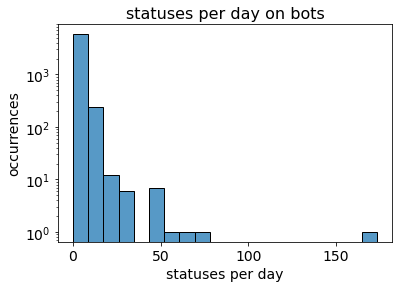

In [ ]:
visualize(data=bots_statuses_per_day, plot_type='hist', bins=20,
          xlabel='statuses per day', ylabel='occurrences', 
          title='statuses per day on bots')

plt.yscale('log')
plt.show()

In [ ]:
bots_statuses_per_day.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9])

count    6116.000000
mean        0.984531
std         4.106812
min         0.000000
25%         0.031185
50%         0.105911
75%         0.158801
80%         0.179142
90%         1.163501
max       173.611336
dtype: float64

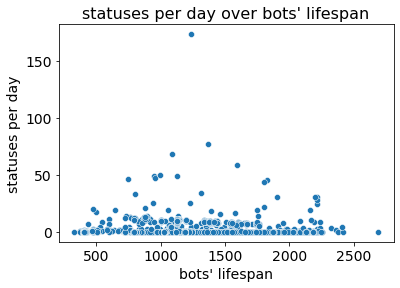

In [ ]:
visualize(x=bots_lifespan, y=bots_statuses_per_day, plot_type='scatter',
          xlabel='bots\' lifespan', ylabel='statuses per day', 
          title='statuses per day over bots\' lifespan')
plt.show()

... it seems pretty much every single bot do not have high statuses_count, except for a single case. We can easily spot an outlier here: the one bot that has over 150 statuses per day (it is not a 'so high value', but since it's the only one we have that differs from the others, we'll drop it.

In [ ]:
pp_users[pp_users.index == bots_statuses_per_day[bots_statuses_per_day.values>150].index[0]]

,lang,bot,created_at,statuses_count,st_per_day
id,,,,,
425528043,en,1,2016-12-02 03:29:05,214410.0,173.611336


In [ ]:
pp_users.drop(bots_statuses_per_day[bots_statuses_per_day.values>150].index[0], inplace=True)

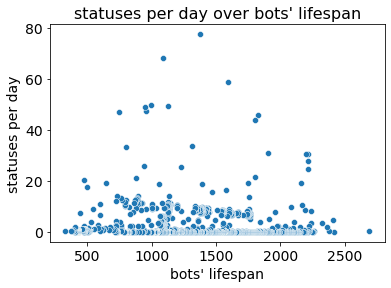

In [ ]:
bots = pp_users.groupby('bot').get_group(1)
bots_statuses_per_day = bots.statuses_count/bots_lifespan
bots_lifespan = bots.created_at.apply(lambda x: today_date-x).dt.days
visualize(x=bots_lifespan, y=bots_statuses_per_day, plot_type='scatter',
          xlabel='bots\' lifespan', ylabel='statuses per day', 
          title='statuses per day over bots\' lifespan')
plt.show()

now it seems quite better, since no point is far distant by the others. There might be a pattern that can be revealed later on the clustering part.

In [ ]:
users_statuses_per_day.max()

3812.2

... as we can see, it is pretty unrealistic to have users that have 3812 tweets per day (also considering the fact twitter permits a maximum of 2400 tweets per day).
These values seem to be weird if we do consider them as standard usesrs. However we cannot be sure that the bot flag is correct and, indeed, they might be outliers over the bot variable (i.e. they are bots and not users).
Let's see how many of these records are there in the dataset: 

In [ ]:
users_statuses_per_day.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9])

count    4993.000000
mean       12.684997
std        63.613183
min      -133.000000
25%         0.133495
50%         2.327320
75%        11.241769
80%        15.397652
90%        30.764966
max      3812.200000
dtype: float64

... we catch a negative minimum. This might be the value of statuses made by the last user registered (since we took the last date present on the dataset as the crawling date)

In [ ]:
users_statuses_per_day[users_statuses_per_day == users_statuses_per_day.min()]

id
3164941860   -133.0
dtype: float64

In [ ]:
users[users.index == 3164941860]

,lang,bot,created_at,statuses_count
id,,,,
3164941860,en,0,2020-04-21 07:28:31,133.0


In [ ]:
neg_outlier_id = 3164941860

In [ ]:
pp_users.created_at.max()

Timestamp('2020-04-21 07:28:31')

In [ ]:
pp_users.drop(neg_outlier_id, inplace=True)

exactly as we thought...
Though , it is pretty weird a user made 133 tweets/retweets in a single day. We might want to consider this data as an outlier one.

Now let's be sure there's no others:

In [ ]:
(users_statuses_per_day < 0).value_counts()

False    5391
True        1
dtype: int64

considering the activity of a user, the 75th percentile (11) still is a high number of tweets per day, meaning them twitting every 1.5 hours every single day. We expect most users do not tweet so often. Although it seems weird, we decide to take for granted all those values below the 90th percentile

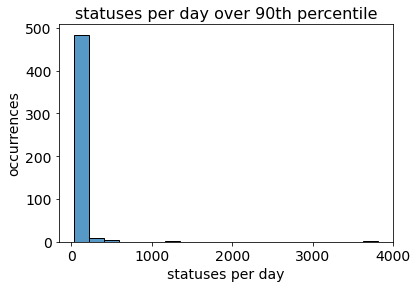

In [ ]:
visualize(data=users_statuses_per_day[users_statuses_per_day > users_statuses_per_day.quantile(0.9)],
          plot_type='hist', bins=20, xlabel='statuses per day', ylabel='occurrences',
          title='statuses per day over 90th percentile')
plt.show()

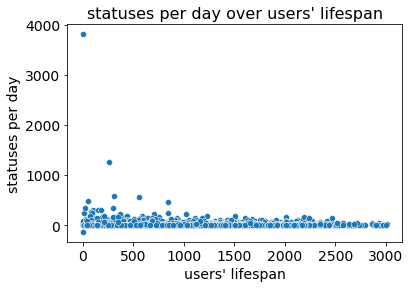

In [ ]:
visualize(x=users_lifespan, y=users_statuses_per_day, plot_type='scatter',
          xlabel='users\' lifespan', ylabel='statuses per day', 
          title='statuses per day over users\' lifespan')
plt.show()

it seems legit to affirm that there one big outlier that we're going to remove.

In [ ]:
pp_users[pp_users.index == users_statuses_per_day[users_statuses_per_day > 3000].index[0]]

,lang,bot,created_at,statuses_count,st_per_day
id,,,,,
3156622237,en,0,2020-04-15 15:17:36,19061.0,3812.2


In [ ]:
pp_users.drop(users_statuses_per_day[users_statuses_per_day > 3000].index[0], inplace=True)

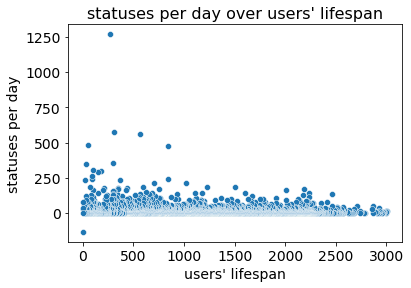

In [ ]:
users = pp_users.groupby('bot').get_group(0)
users_statuses_per_day = users.statuses_count/users_lifespan
users_lifespan = users.created_at.apply(lambda x: today_date-x).dt.days
visualize(x=users_lifespan, y=users_statuses_per_day, plot_type='scatter',
          xlabel='users\' lifespan', ylabel='statuses per day', 
          title='statuses per day over users\' lifespan')
plt.show()

still, it seems there is one more outlier left. Let's get rid of it too.

In [ ]:
pp_users.drop(users_statuses_per_day[users_statuses_per_day > 1000].index[0], inplace=True)

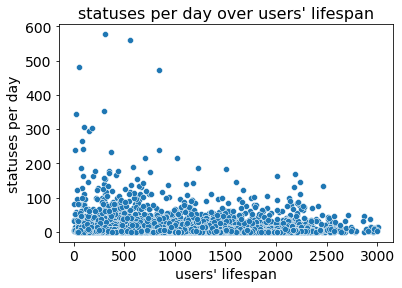

In [ ]:
users = pp_users.groupby('bot').get_group(0)
users_statuses_per_day = users.statuses_count/users_lifespan
users_lifespan = users.created_at.apply(lambda x: today_date-x).dt.days
visualize(x=users_lifespan, y=users_statuses_per_day, plot_type='scatter',
          xlabel='users\' lifespan', ylabel='statuses per day', 
          title='statuses per day over users\' lifespan')
plt.show()

now, it is more clear that there might be a pattern looking at some users that can reveal something interesing.

### 1.1.4 Nan Handling

Now, let's handle those nan values we have from statuses_count. We will repair those values, replacing them with the median of statuses_count made per day based on user cateogry (legit user/bot)

Let's see how:

In [ ]:
users.statuses_count.isna().value_counts()

False    4993
True      399
Name: statuses_count, dtype: int64

... all the nan values come from users' data

In [ ]:
users_statuses_per_day.describe()

count    4990.000000
mean       11.701289
std        28.889142
min         0.000000
25%         0.133495
50%         2.319196
75%        11.236729
max       577.003215
dtype: float64

now let's use the median value to assign every nan statuses_count:

In [ ]:
nn_users_lifespan = users[users.statuses_count.isnull()].created_at.apply(lambda x: today_date-x).dt.days
users_new_values = nn_users_lifespan * users_statuses_per_day.mean()

In [ ]:
pp_users['statuses_count'].fillna(users_new_values, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
pp_users.statuses_count.isna().value_counts()

False    11504
Name: statuses_count, dtype: int64

... we have replaced all the nan values with the number of statuses those users would have made based on the statuses_per_day median.

### 1.1.5 Save and load v2 checkpoint

In [ ]:
#pp_users.to_csv(basepath + '/pp_users_v2.csv')

In [ ]:
pp_users = pd.read_csv(basepath + '/pp_users_v2.csv', index_col='id', parse_dates=['created_at'])

## 1.2 Analysis on tweets' dataset





### 1.2.1 General dataset exploration

In [ ]:
raw_tweets.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              13664694 non-null  object
 1   user_id         13447413 non-null  object
 2   retweet_count   13227562 non-null  object
 3   reply_count     13016818 non-null  object
 4   favorite_count  13017154 non-null  object
 5   num_hashtags    12607172 non-null  object
 6   num_urls        13016073 non-null  object
 7   num_mentions    12810531 non-null  object
 8   created_at      13664696 non-null  object
 9   text            13126975 non-null  object
dtypes: object(10)
memory usage: 1.0+ GB


... as we can observe, we have multiple null-values throughout the attributes. We don't like having null values for ids and user_ids.

#### 1.2.1.1 General assumptions

Let's see what those null ids are:

In [ ]:
raw_tweets[raw_tweets['id'].isnull()]

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
9706367,NaN,466475273,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-08 07:09:46,NaN
12171674,NaN,87334609,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-13 01:10:44,NaN


... as we can see they carry no information, thus we can drop them:

In [ ]:
raw_tweets.dropna(subset=['id'], inplace=True)

for now let's assume that if a recod has USER ID nan, we choose to drop it because we need to match user info

In [ ]:
len(raw_tweets)

13664694

In [ ]:
raw_tweets.dropna(subset=["user_id"], inplace=True)

In [ ]:
len(raw_tweets)

13447411

Let's make the assumption that if two records are exactly equal, only one should be in the daset, so we drop exact duplicates:

In [ ]:
raw_tweets.drop_duplicates(inplace=True)

In [ ]:
len(raw_tweets)

11495312

#### 1.2.1.2 Enforcing types

that we expect from each column: (not numericals are replaced by nans)

In [ ]:
numerical_features = [
 'retweet_count',
 'reply_count',
 'favorite_count',
 'num_hashtags',
 'num_urls',
 'num_mentions',
 ]

In [ ]:
raw_tweets[numerical_features] = raw_tweets[numerical_features].apply(pd.to_numeric, errors='coerce') #coerce will force non numeric to nans

In [ ]:
raw_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11495312 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   user_id         object 
 2   retweet_count   float64
 3   reply_count     float64
 4   favorite_count  float64
 5   num_hashtags    float64
 6   num_urls        float64
 7   num_mentions    float64
 8   created_at      object 
 9   text            object 
dtypes: float64(6), object(4)
memory usage: 964.7+ MB


In [ ]:
raw_tweets['user_id'] = raw_tweets.user_id.apply(pd.to_numeric, errors='ignore') #transforming into numerical besides literals

In [ ]:
#this way the 'created_at' column will be accessible as a datetime object
raw_tweets['created_at'] = pd.to_datetime(raw_tweets.created_at)

In [ ]:
raw_tweets.created_at

0          2019-09-11 14:53:55
1          2020-04-01 20:27:04
2          2019-05-02 13:34:31
3          2019-11-04 07:17:37
4          2020-03-11 16:45:31
                   ...        
13664690   2018-05-04 05:29:33
13664691   2020-04-17 02:51:53
13664693   2016-07-10 22:43:09
13664694   2019-03-07 19:56:55
13664695   2019-07-10 12:00:00
Name: created_at, Length: 11495312, dtype: datetime64[ns]

...as we can see dtype is now datetime64

#### 1.2.1.3 IDs uniqueness



Let's look if IDs are unique. If that is not the case, we can consider to drop that column, after further investigation, because it may not represent the concept of IDs and carry no useful information. 

In [ ]:
len(raw_tweets.id.unique()) == len(raw_tweets)

False

... as we can observe, there are duplicated IDs. Considering the fact we already dropped any identical row, these are not representing the same tweet, meaning they are violating the concept of their column name.

We consider to drop the column, since it is not useful or representative of any concept:


In [ ]:
raw_tweets.drop(columns=['id'], inplace=True)

#### 1.2.1.4 Looking at duplicates

although we dropped any identical duplicate, we might also want to check for those tweets who, even though having different values for any other column, do have identical values for the tuple (user_id, created_at). This is motivated by the obvious fact that there cannot exist two tweets who do share these 2 information altogether.

Let's check if there are any:

In [ ]:
raw_tweets.duplicated(subset=['user_id', 'created_at'], keep=False).value_counts()

False    8611399
True     2883913
dtype: int64

if we were to throw away all nans in the dataset we would loose:

In [ ]:
len(raw_tweets) - len(raw_tweets.dropna(subset=["retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions", "text"]))

1641825

if after dropna we look for duplicates:

In [ ]:
len(raw_tweets.dropna(subset=["retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions","text"])) - len((raw_tweets.dropna(subset=["retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions", "text"])).duplicated(subset=["user_id", "created_at"],keep=False))

0

So removing all the nans in the dataset will also remove all the duplicates, but can we do better, loosing lesss records?

If we would solve all the duplicates we would loose:

In [ ]:
len(raw_tweets[raw_tweets.duplicated(subset=["user_id", "created_at"])])

1451513

... leaving us with a total record of:

In [ ]:
len(raw_tweets.drop_duplicates(subset=['user_id', 'created_at']))

10043799

This is a bit better, but when solving the duplicated records we are just randomly picking one out of each group (the first one)... can we do better?


We will define a metric to show which row holds more information so that we can choose the "best row" instead of a random one. Let's dive in:


#### 1.2.1.5 Duplicates and information_score

Let's try a fine approach: we will try to keep only the records that carry the most information

we identify a metric called "information_score" which for each row counts the number of nans in the numerical columns. Lower the number more the information.


Thanks to this rating (which will account for the information lost) we'll select the best row out of each group of the so defined identical tweets.


Let's see how:

In [ ]:
cols = ["retweet_count", 	"reply_count", 	"favorite_count", 	"num_hashtags", 	"num_urls", 	"num_mentions", "text"]

In [ ]:
#def information_score(row):
#  return row[cols].isnull().sum().sum()
#one line at the time, takes forever
#raw_tweets["information_score"] = raw_tweets.apply(information_score, axis=1)
#this takes forever!

In [ ]:
#with the power of matrices, a few seconds!
raw_tweets["information_score"] = raw_tweets[cols].isnull().sum(axis=1)

so we sort based on the information score, then we group by the identifying key, and we keep only the first record, which represent the greatest possible knowledge among the duplicates

In [ ]:
#sorting with matrices is also fast
raw_tweets.sort_values("information_score", inplace=True)

In [ ]:
keys=["user_id", "created_at"] # we do not use text in the key any more, we keep the non nan, and if multiple not-nan we keep at random
gb = raw_tweets.groupby(keys) # we can do this because "user_id" and "created_at" are never nan

In [ ]:
raw_tweets = gb.first().sort_values("information_score").reset_index()

In [ ]:
len(raw_tweets)

10043799

... as we can see, the number of total rows matches the number we've seen above (representing rows - rows with identical tuple(user_id, created_at)

In [ ]:
#raw_tweets.text.isnull().value_counts()
#... we found out that using groupby with "text" as an index, deletes all the nan
# when passing an index to groupby it is necessary not to have nans, or these values will be dropped.

so we removed unexpected duplicates: no user can publish more than 1 tweet at the same time. When that happens, we consider all these records as the same tweet.


In [ ]:
raw_tweets.information_score.value_counts()

0    9808521
1     124427
4      72103
5      36869
6        878
7        676
2        325
Name: information_score, dtype: int64

In [ ]:
len(raw_tweets[raw_tweets.information_score>0])/len(raw_tweets)

0.023425199966665998

we can observ that the records' information_scores have such a distribution
```
*   0 -> 9839605
*   1 ->   86294
*   2 ->       0
*   3 ->       0
*   4 ->   39533
*   5 ->   14413
*   6 ->     231
```
if we delete all values with score>1 we'll only loose 2.3% of the dataset, which is way less than deleting all the nan ahead. Our groupby operation has already eliminated roughly 9% of the dataset, whithout loosing all those records.


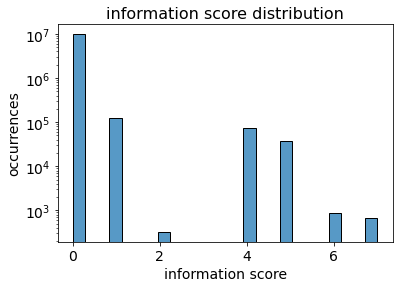

In [ ]:
visualize(data=raw_tweets.information_score, plot_type='hist',
          xlabel='information score', ylabel='occurrences', title='information score distribution')
plt.yscale('log')
plt.show()

#### 1.2.1.6 Match user-ids
We're going to split tweets dataset leaving back un-matched user_ids by user's dataset (literlas and non-matching numerical)

In [ ]:
intersection = set(pp_users.index.values).intersection(set(raw_tweets.user_id.values))

In [ ]:
len(intersection)

11504

... as we can observe, each user has at least one interaction. 

Now let's get id-matched and id-unmatched rows:

In [ ]:
tweets_matched_ids = raw_tweets[raw_tweets.user_id.isin(intersection)]

In [ ]:
len(tweets_matched_ids)

9817930

In [ ]:
tweets_unmatched_ids = raw_tweets[~raw_tweets.user_id.isin(intersection)]

In [ ]:
len(tweets_unmatched_ids)

225869

We lose less than 500k tweets by non-matching ids. And that seems fine.

In [ ]:
pp_tweets = tweets_matched_ids

In [ ]:
pp_tweets.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9817930 entries, 0 to 9932947
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   user_id            9817930 non-null  object        
 1   created_at         9817930 non-null  datetime64[ns]
 2   retweet_count      9817930 non-null  float64       
 3   reply_count        9817930 non-null  float64       
 4   favorite_count     9817930 non-null  float64       
 5   num_hashtags       9817930 non-null  float64       
 6   num_urls           9817930 non-null  float64       
 7   num_mentions       9817930 non-null  float64       
 8   text               9779894 non-null  object        
 9   information_score  9817930 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 824.0+ MB


### 1.2.2 Save and load checkpoint
We'll save the current working dataset of tweets and work on it from now on

In [ ]:
tweets_matched_ids.to_csv(basepath+"/pp_tweets.csv")

In [ ]:
pp_tweets = pd.read_csv(basepath + '/pp_tweets.csv', lineterminator='\n', index_col=0, parse_dates=['created_at'])

### 1.2.3 Data visualization and outliers handling

#### 1.2.3.1 Correlation matrix

We can now try to gather better knowledge about our dataset by looking at the correlation matrix between the numerical columns



In [ ]:
class Correlation():
  def __init__(self,df):
    self.df = df
    self.df["created_at_numerical"] = self.df.created_at.view(np.int64)

  def compute(self,frac):
    self.mx = self.df[["created_at_numerical","retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions"]].sample(frac=frac).corr()
  def heatmap(self):
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(self.mx)
    im.set_clim(-1,1)
    fig.colorbar(im, orientation='vertical', fraction = 0.05)

    # Show and rotate ticks
    plt.xticks(np.arange(len(self.mx.columns)),self.mx.columns, rotation=90, fontsize=15)
    plt.yticks(np.arange(len(self.mx.index)),self.mx.index, rotation=0, fontsize=15)

    # Add numerical values
    for i in range(len(self.mx.columns)):
        for j in range(len(self.mx.index)):
            text = ax.text(j, i, round(self.mx.to_numpy()[i, j], 2),
                          ha="center", va="center", color="black")

    plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


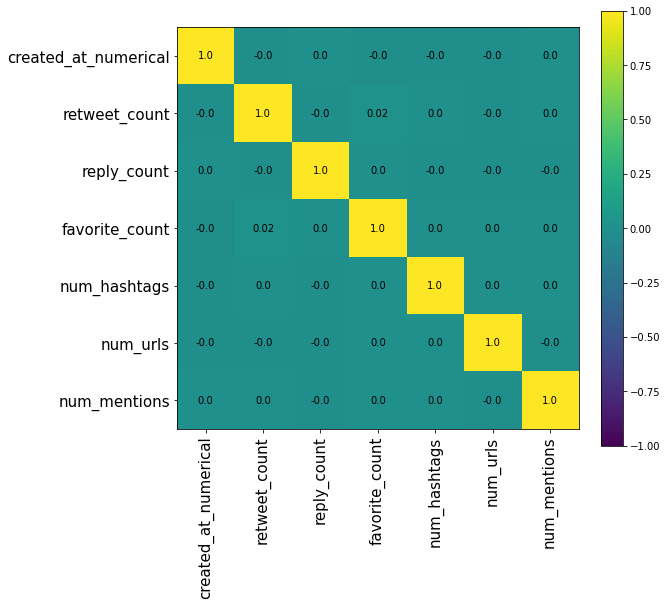

In [ ]:
corr = Correlation(pp_tweets)
corr.compute(0.1)
corr.heatmap()

We observe no significant correlation on the dataset

#### 1.2.3.2 Date analysis

Let's analyze the date of creation of the tweets:

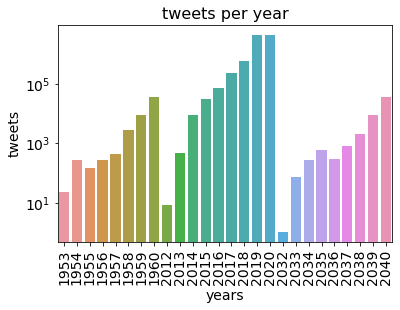

In [ ]:
tweets_per_year = pp_tweets.created_at.apply(lambda x: x.year).value_counts().sort_index()
visualize(x=tweets_per_year.index, y=tweets_per_year.values,
          xlabel='years', ylabel='tweets', title='tweets per year', plot_type='barplot')
plt.yscale('log')
plt.xticks(rotation = 90)
plt.show()

We see something very strange, there are tweets in the future and previous to the date of creation of Twitter. The tweets of the dataset have been created between 2012 and 2020. Let's analyze the impossible tweets:

In [ ]:
p = len(pp_tweets[pp_tweets.created_at< pd.to_datetime("2012-01-01")])
f = len(pp_tweets[pp_tweets.created_at> pd.to_datetime("2020-12-22")])
t = p + f
print("Tweets before 2012: ", p)
print("Tweets after 2020: ", f)
print("Total out-of-bounds tweets: ", t)
print("Percentage of out-of-bounds tweets: ", round((t/len(pp_tweets))*100, 3), end='')
print("%")

Tweets before 2012:  48707
Tweets after 2020:  48677
Total out-of-bounds tweets:  97384
Percentage of out-of-bounds tweets:  0.992%


Almost 1% of the tweets have a date which does not respect the bounds. We can notice something very strange. It seems that some tweets have been translated by 60 years in the past or 20 years in the future. We could think about moving these tweets in the admissible range. This is a strong assumption we can not do in general on a real dataset. However, looking at the distributions of the past, present and future tweets, they seems almost identical. For this reason, we can actually bring them to the present without changing the data distribution

In [ ]:
(pp_tweets.created_at[pp_tweets.created_at< pd.to_datetime("1961-01-01")]) = (pp_tweets.created_at[pp_tweets.created_at< pd.to_datetime("1961-01-01")]) + pd.offsets.DateOffset(years=60)
(pp_tweets.created_at[pp_tweets.created_at>= pd.to_datetime("2032-01-01")]) = (pp_tweets.created_at[pp_tweets.created_at>= pd.to_datetime("2032-01-01")]) + pd.offsets.DateOffset(years=-20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


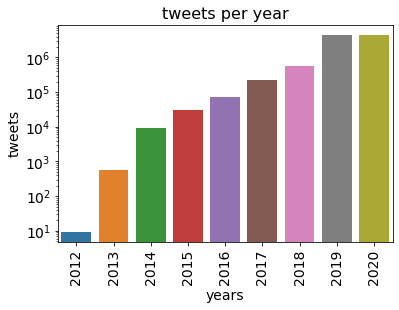

In [ ]:
tweets_per_year = pp_tweets.created_at.apply(lambda x: x.year).value_counts().sort_index()
visualize(x=tweets_per_year.index, y=tweets_per_year.values,
          xlabel='years', ylabel='tweets', title='tweets per year', plot_type='barplot')
plt.yscale('log')
plt.xticks(rotation = 90)
plt.show()

#### 1.2.3.3 Boxplots

We can now try to gather better knowledge about our dataset by looking at the box plots/graphs



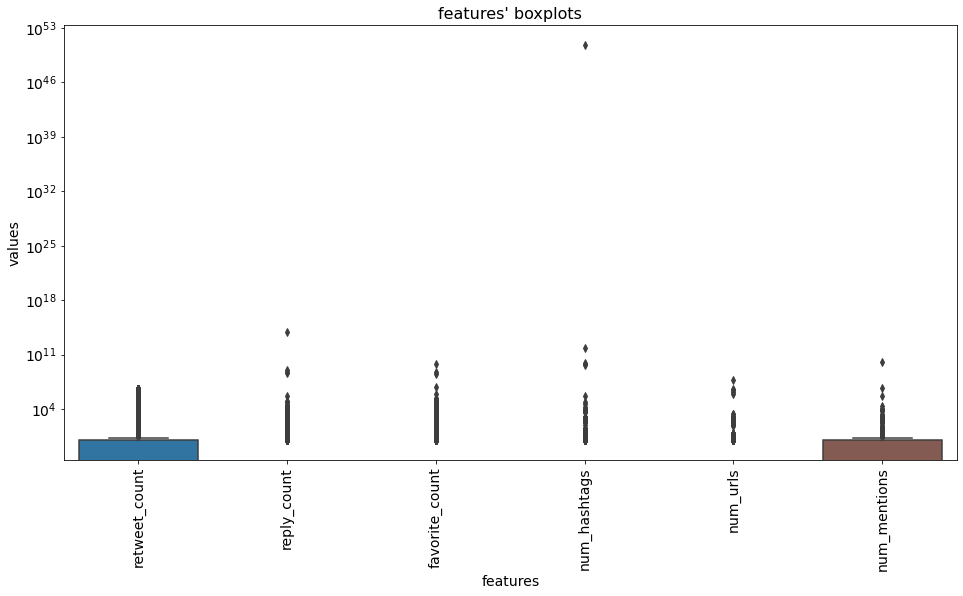

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

we spot a big outlier here, that we are going to remove instantly

In [ ]:
pp_tweets[pp_tweets['num_hashtags']>1e25]

,user_id,created_at,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,text,information_score
5106328,157883888,2019-11-02 16:53:24,0.0,0.0,0.0,6.200000e+50,0.0,0.0,"You maniacs! You blew it up! Oh, damn you! Dam...",0


In [ ]:
pp_tweets.drop(pp_tweets[pp_tweets['num_hashtags']>1e25].index[0], inplace=True)

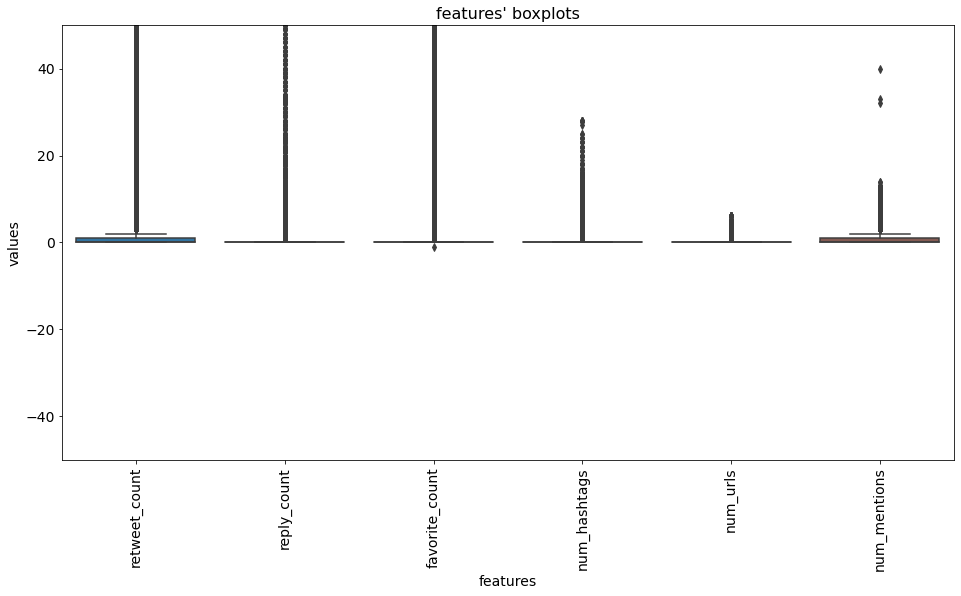

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.ylim(-50,50)
plt.show()

as we can see by the boxplot there is one negative value on favorite_count

In [ ]:
print('-1 favorite_count: ', len(pp_tweets[pp_tweets['favorite_count']==-1]))

-1 favorite_count:  1


In [ ]:
pp_tweets.favorite_count.replace(-1, 0, inplace=True)

In [ ]:
print('dataset rows: ', len(pp_tweets))
print('number of reply_count<1: ', len(pp_tweets[pp_tweets['reply_count']<1]))
print('number of favorite_count<1: ', len(pp_tweets[pp_tweets['favorite_count']<1]))
print('number of num_hashtags<1: ', len(pp_tweets[pp_tweets['num_hashtags']<1]))
print('number of num_mentions<1: ', len(pp_tweets[pp_tweets['num_mentions']<1]))

dataset rows:  9817929
number of reply_count<1:  9801361
number of favorite_count<1:  7866238
number of num_hashtags<1:  8714333
number of num_mentions<1:  5843906


as we can see most of the numerical value of tweets are set to 0.

Let's focus on the fields concerning the text of the tweet:

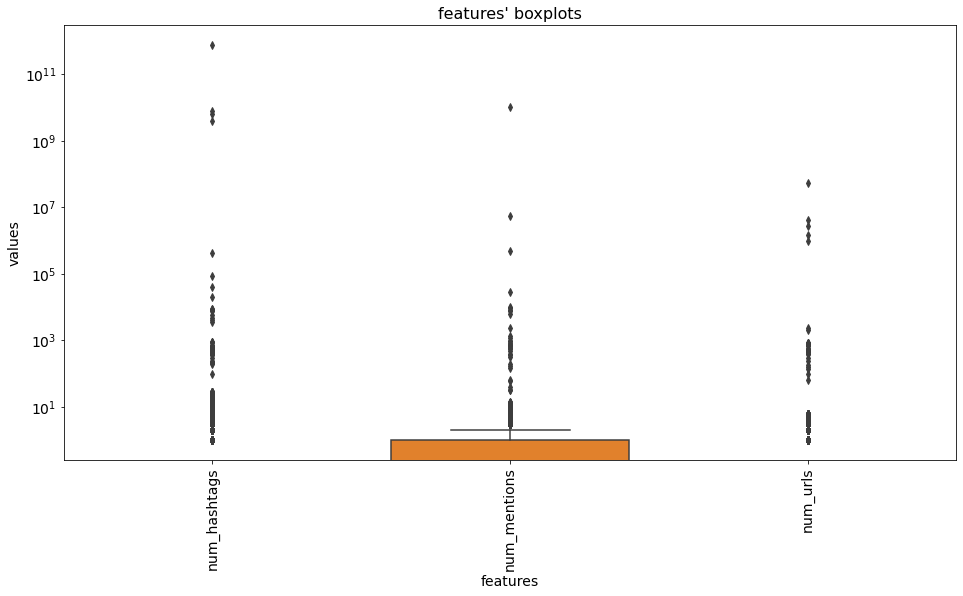

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["num_hashtags","num_mentions","num_urls"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

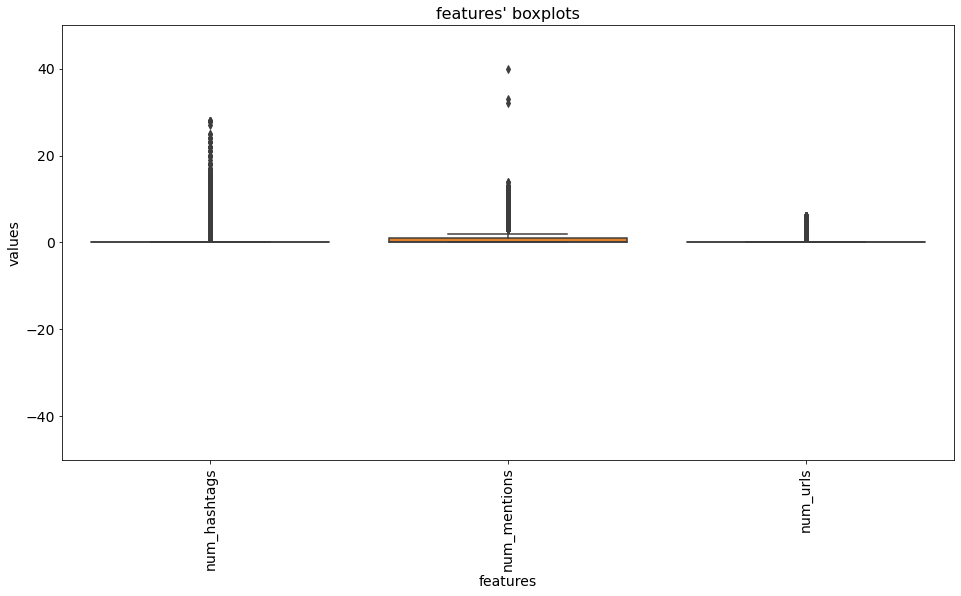

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["num_hashtags","num_mentions","num_urls"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.ylim(-50, 50)
plt.show()

The number of mentions, urls  and hashtags is limited by the number of characters in a Tweet, which is 280 (140 before the 2017). This is a very rough limit, since each mention or url has a length greater than 1. We look at the tweets with more than the allowed number of mentions or urls or hashtags:

In [ ]:
print("Tweets with more than 46 mentions:", len(pp_tweets[pp_tweets["num_mentions"]>46]))
print("Tweets with more than 46 urls:", len(pp_tweets[pp_tweets["num_urls"]>46]))
print("Tweets with more than 93 hashtags", len(pp_tweets[pp_tweets["num_hashtags"]>93]))
print(len(pp_tweets[(pp_tweets["num_urls"]>46) & (pp_tweets["num_mentions"]>46)]))
print(len(pp_tweets[(pp_tweets["num_urls"]>46) & (pp_tweets["num_hashtags"]>93)]))
print(len(pp_tweets[(pp_tweets["num_hashtags"]>93) & (pp_tweets["num_mentions"]>46)]))

Tweets with more than 46 mentions: 32
Tweets with more than 46 urls: 32
Tweets with more than 93 hashtags 43
0
0
0


The three sets are disjoint, so we have a total of 107 records which surely do not respect the tweet length limit

In [ ]:
print("Percentage of tweets with too many urls or mentions: {}%".format(round((107/len(pp_tweets))*100, 3), end=''))

Percentage of tweets with too many urls or mentions: 0.001%


since this is a low percentage, we can be sure that these values represent real outliers.

Hence, we decide to drop them:

In [ ]:
pp_tweets.drop((pp_tweets[pp_tweets["num_mentions"]>46]).index, inplace=True)
pp_tweets.drop((pp_tweets[pp_tweets["num_urls"]>46]).index, inplace=True)
pp_tweets.drop((pp_tweets[pp_tweets["num_hashtags"]>93]).index, inplace=True)

We check that, for tweets before 2017, the same thing holds with half of the characters:

In [ ]:
print("Tweets before 2017 with more than 70 mentions:", len(pp_tweets[(pp_tweets.created_at<pd.to_datetime("2017-11-01")) & pp_tweets["num_mentions"]>23]))
print("Tweets before 2017 with more than 70 mentions:", len(pp_tweets[(pp_tweets.created_at<pd.to_datetime("2017-11-01")) & pp_tweets["num_urls"]>23]))
print("Tweets before 2017 with more than 70 mentions:", len(pp_tweets[(pp_tweets.created_at<pd.to_datetime("2017-11-01")) & pp_tweets["num_hashtags"]>47]))

Tweets before 2017 with more than 70 mentions: 0
Tweets before 2017 with more than 70 mentions: 0
Tweets before 2017 with more than 70 mentions: 0


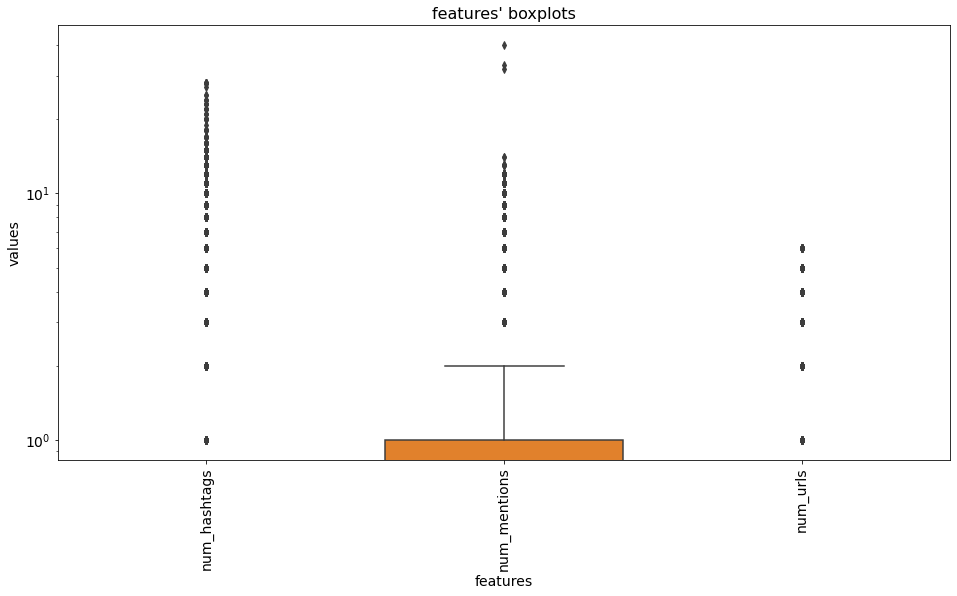

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["num_hashtags","num_mentions","num_urls"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

Now it looks better

Let's now analyze the fields representing the interactions of a tweet:

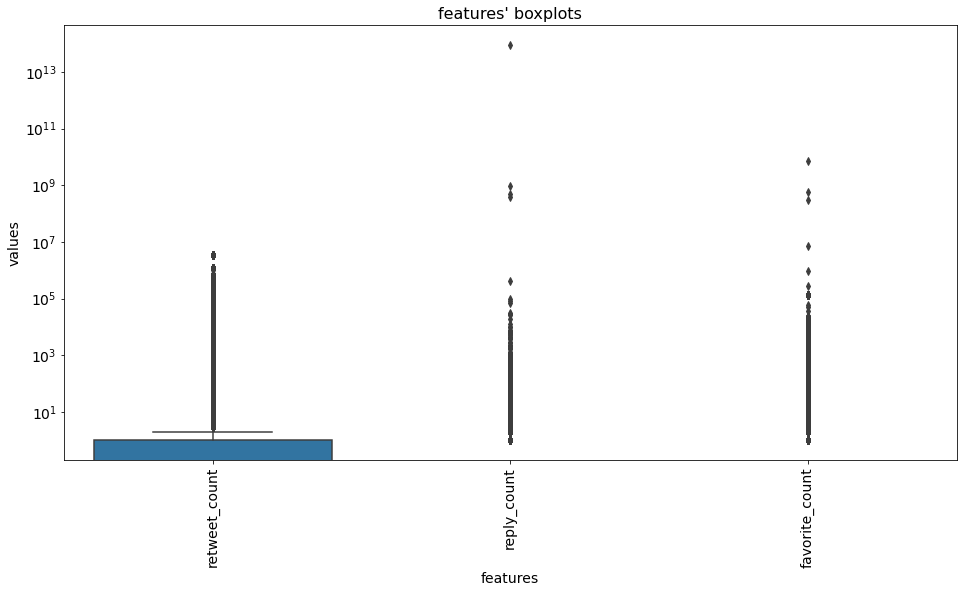

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["retweet_count","reply_count","favorite_count"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

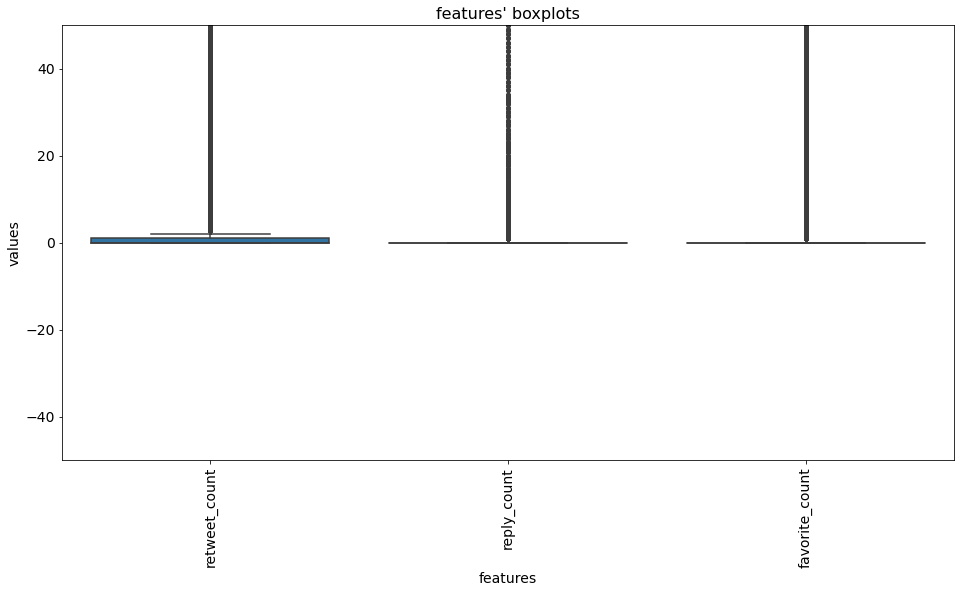

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["retweet_count","reply_count","favorite_count"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.ylim(-50, 50)
plt.show()

Since the most-liked tweet has 7.1 millions of likes (source: https://en.wikipedia.org/wiki/List_of_most-liked_tweets), we can conclude that some of the outliers we see in the boxplot above are wrong values. So, let's see how many tweets have a wrong favorite_count value:

In [ ]:
len(pp_tweets[pp_tweets["favorite_count"]>72*(10**5)])

3

Again, since they are just 3, we drop them

In [ ]:
pp_tweets.drop((pp_tweets[pp_tweets["favorite_count"]>72*(10**5)]).index, inplace=True)

As we did for the favorites, we saw that the most retweeted tweet has 4 millions of retweets (source: https://en.wikipedia.org/wiki/List_of_most-retweeted_tweets). It seems from the boxplot that we don't have numbers of retweets greater than that. But let's see the number:

In [ ]:
len(pp_tweets[pp_tweets["retweet_count"]>4*(10**6)])

0

Regarding the replies, we have not found information about the most replied tweets, so we take a deeper look at this field.
Let's start with records with very unlikely values:

In [ ]:
print(len(pp_tweets[pp_tweets["reply_count"]>10**7]))
print("Percentage of tweets with more than 10^13 replies", round((len(pp_tweets[pp_tweets["reply_count"]>10**7])/len(pp_tweets)*100),3), end='')
print("%")

4
Percentage of tweets with more than 10^13 replies 0.0%


In [ ]:
pp_tweets[pp_tweets["reply_count"]>10**7]

,user_id,created_at,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,text,information_score,created_at_numerical
7292877,41242157,2020-03-23 20:52:49,0.0,4.000000e+08,0.0,0.0,0.0,1.0,@JonoNewton I don't understand parents like th...,0,1584996769000000000
7719469,402694459,2019-03-28 09:21:16,0.0,5.000000e+08,0.0,0.0,0.0,0.0,My favorite!!!! http://t.co/COcSYNadCg,0,1553764876000000000
8568606,466394269,2019-11-03 08:08:41,0.0,9.000000e+13,1.0,0.0,0.0,0.0,I grandi dubbi!! Ma in prossimita' delle isole...,0,1572768521000000000
9513986,364100451,2020-04-26 03:46:21,0.0,9.130000e+08,0.0,0.0,0.0,2.0,@DIEJAMES @_Njay3 Nah Parker and Ginobli are w...,0,1587872781000000000


In [ ]:
for outlier in pp_tweets[pp_tweets["reply_count"]>10**7].index:
  pp_tweets.drop(outlier, inplace=True)

Let's look further into these features:

In [ ]:
t = len(pp_tweets)
z_reply_count = len(pp_tweets[pp_tweets.reply_count == 0])
z_favorite_count = len(pp_tweets[pp_tweets.favorite_count == 0])
z_retweet_count = len(pp_tweets[pp_tweets.retweet_count == 0])
print("Total tweets:", t)
print("Tweets with zero reply_count:", z_reply_count)
print("Tweets with zero favorite_count:", z_favorite_count)
print("Tweets with zero retweet_count:", z_retweet_count)
print("Percentage of tweets with zero reply_count: {}%".format(round( (z_reply_count/t)*100, 3 ), end=''))
print("Percentage of tweets with zero favorite_count: {}%".format(round( (z_favorite_count/t)*100, 3 ), end=''))
print("Percentage of tweets with zero retweet_count: {}%".format(round( (z_retweet_count/t)*100, 3 ), end=''))

Total tweets: 9817815
Tweets with zero reply_count: 9801251
Tweets with zero favorite_count: 7866149
Tweets with zero retweet_count: 7086524
Percentage of tweets with zero reply_count: 99.831%
Percentage of tweets with zero favorite_count: 80.121%
Percentage of tweets with zero retweet_count: 72.18%


It's clear at this point that the reply_count column gives us no information. We want to drop it, but first, let's ensure that we did not messed up the dataset at the beginning:

In [ ]:
t = len(raw_tweets)
n = len(raw_tweets.reply_count[raw_tweets.reply_count.isnull()])
z = len(raw_tweets[raw_tweets.reply_count == 0])
print("Total tweets:", t)
print("Tweets with NaN reply_count:", n)
print("Tweets with zero reply_count", z)
print("Percentage of tweets with NaN and zeros reply_count: {}%".format(round(((n+z)/t)*100, 3 ), end=''))

Total tweets: 10043799
Tweets with NaN reply_count: 77773
Tweets with zero reply_count 9949163
Percentage of tweets with NaN and zeros reply_count: 99.832%


So, the column has never carried enough information. Hence, we drop it:

In [ ]:
pp_tweets.drop(columns=["reply_count"],inplace=True)

Since we can't even see the box of favorite_count, let's see if this field have the same problem:

In [ ]:
pp_tweets.favorite_count.value_counts()

0.0        7866149
1.0        1173681
2.0         339223
3.0         152640
4.0          83526
            ...   
889.0            1
20094.0          1
282.0            1
561.0            1
4278.0           1
Name: favorite_count, Length: 1310, dtype: int64

First, we ensure that every value is >= 0

In [ ]:
pp_tweets.drop((pp_tweets[pp_tweets["favorite_count"]<0]).index, inplace=True)

It seems that this column does not have this problem, however the distribution has a very long tail.

In [ ]:
pp_tweets.favorite_count.describe()

count    9.817815e+06
mean     2.615771e+00
std      2.271730e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.000000e+06
Name: favorite_count, dtype: float64

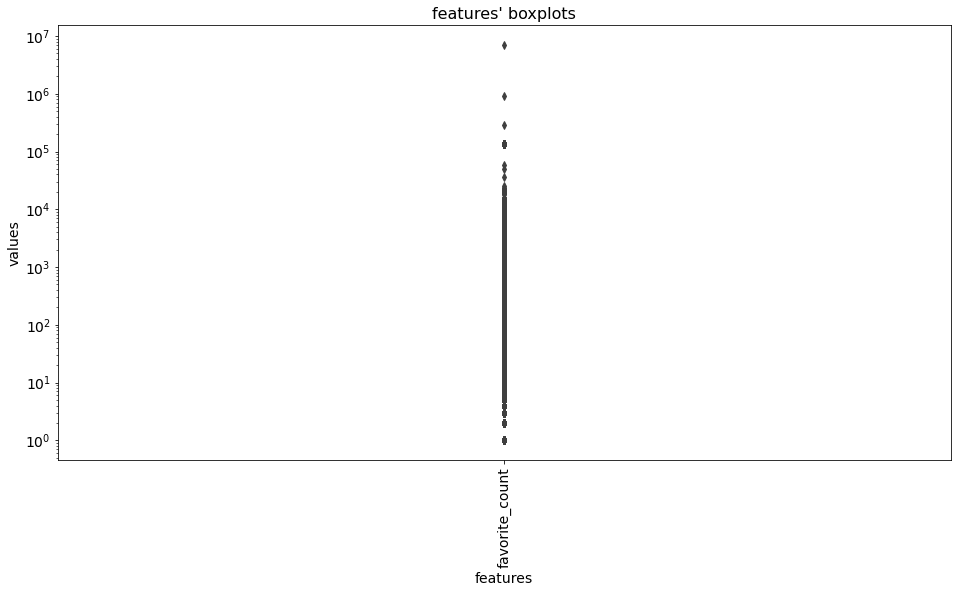

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["favorite_count"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

We can keep them all, there is no valid cause to consider some of these values as outliers.

Let's have a look at retweet_count better:


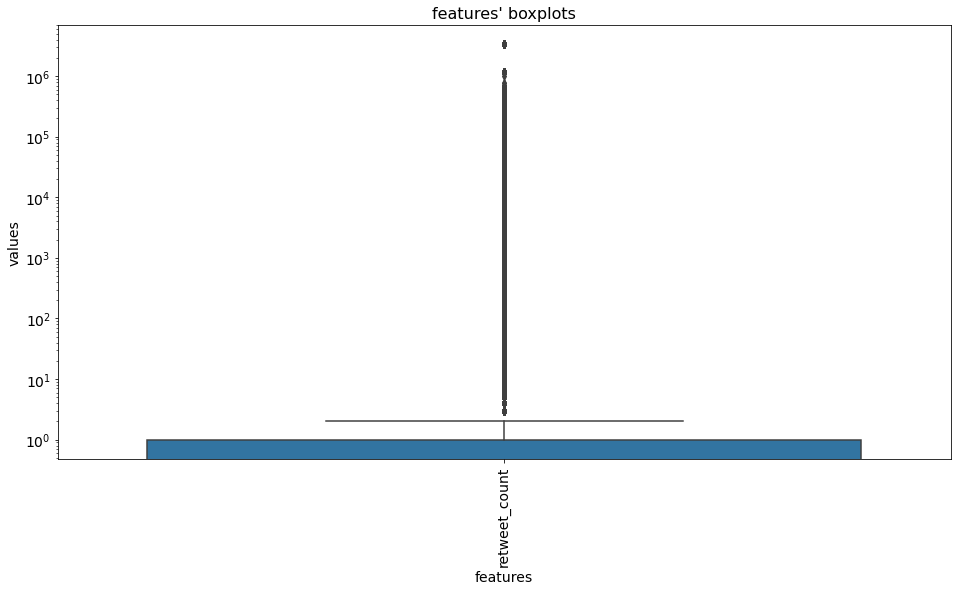

In [ ]:
fig = plt.figure(figsize=(16,8))
bx = pp_tweets[["retweet_count"]]
visualize(data=bx, plot_type='boxplot', xlabel='features', ylabel='values', title='features\' boxplots')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

also no valid cause to consider some of these values outliers. We can keep them all.

#### 1.2.3.4 Text

Now we move to the text field. One thing we want to check is the length of the tweet.

Let's start with too long tweets:

In [ ]:
pp_tweets["text_length"] = pp_tweets.text.apply(lambda x :len(str(x)))

In [ ]:
len(pp_tweets[pp_tweets['text_length']>280])

529

we can see there are some tweets with over 280 chars.

In [ ]:
#tweet lenght is limited
pp_tweets = pp_tweets[pp_tweets.text_length<=280]

Before november 2017 the text length limit was 140 characters

In [ ]:
len(pp_tweets[(pp_tweets.created_at < pd.to_datetime("2017-11-01")) & (pp_tweets.text_length>140)])

9841

In [ ]:
len(pp_tweets[(pp_tweets.created_at < pd.to_datetime("2017-11-01")) & (pp_tweets.text_length>140)])/len(pp_tweets)

0.0010024155352100367

We drop these records

In [ ]:
pp_tweets.drop((pp_tweets[(pp_tweets.created_at < pd.to_datetime("2017-01-01")) & (pp_tweets.text_length>140)]).index, inplace=True)

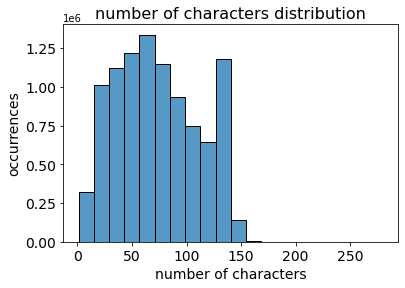

In [ ]:
visualize(data=pp_tweets.text_length, plot_type='hist', bins=20, 
          xlabel='number of characters', ylabel='occurrences', title='number of characters distribution')
plt.show()

In [ ]:
# pp_tweets.drop(columns=["text_length"],inplace=True)

#### 1.2.3.5 Graphs

We take a look at the information score after all the edits we did:

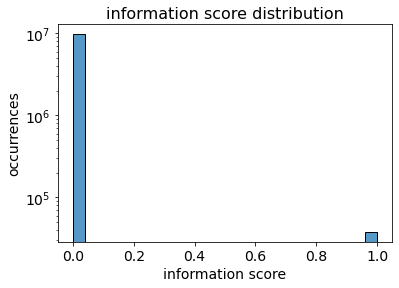

In [ ]:
visualize(data=pp_tweets.information_score, plot_type='hist',
          xlabel='information score', ylabel='occurrences', title='information score distribution')
plt.yscale('log')
plt.show()

In [ ]:
print("records with information_score = 1: {}%".format(round((len(pp_tweets[pp_tweets["information_score"]==1])/len(pp_tweets))*100, 3), end=''))

records with information_score = 1: 0.388%


We see that, almost every record (>99,6%) has an information score of 0, which is the best we can ask for

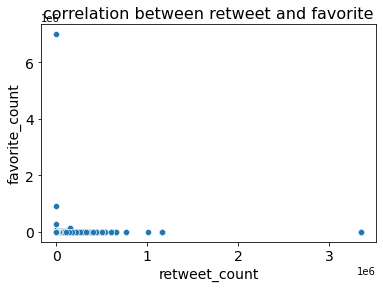

In [ ]:
visualize(x=pp_tweets.retweet_count, y=pp_tweets.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.show()

we'll remove these points

In [ ]:
pp_tweets[pp_tweets['favorite_count']>0.5e6]

,user_id,created_at,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,text,information_score,charnum
524427,613459090,2019-11-01 20:05:45,0.0,7000000.0,0.0,0.0,0.0,Io amo le persone che mi dimostrano il proprio...,0,61
4583477,2281337544,2019-11-01 19:39:13,0.0,922462.0,0.0,0.0,0.0,Il segreto per andare d'accordo con le donne? ...,0,60


In [ ]:
pp_tweets.drop(pp_tweets[pp_tweets['favorite_count']>0.5e6].index, inplace=True)

In [ ]:
pp_tweets[pp_tweets['retweet_count']>2e6]

,user_id,created_at,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,text,information_score,charnum
137540,616602934,2019-03-05 03:06:44,3350105.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99
220472,731955936,2019-03-05 03:24:54,3350093.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99
226133,737521098,2019-03-05 04:15:44,3350093.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99
326805,578716380,2019-03-05 03:21:04,3350109.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99
491549,612129754,2019-03-05 05:31:55,3350105.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99
...,...,...,...,...,...,...,...,...,...,...
9286931,342527071,2019-03-05 03:07:55,3350041.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99
9494392,368134512,2019-03-05 03:07:15,3350040.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99
9507303,361943550,2019-03-05 19:25:51,3350041.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99
9542040,324487766,2019-03-05 03:07:10,3350059.0,0.0,1.0,0.0,1.0,RT @TheEllenShow: If only Bradley's arm was lo...,0,99


they seem to be far distant from other points + they kinda have the same information. thus we decide to drop them

In [ ]:
pp_tweets.drop(pp_tweets[pp_tweets['retweet_count']>2e6].index, inplace=True)

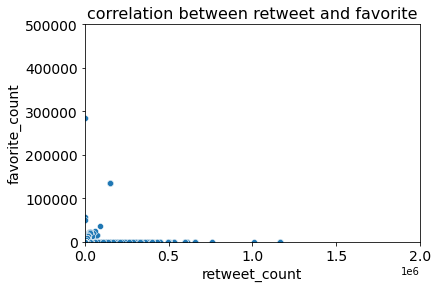

In [ ]:
visualize(x=pp_tweets.retweet_count, y=pp_tweets.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.xlim(0, 2e6)
plt.ylim(0, 0.5e6)
plt.show()

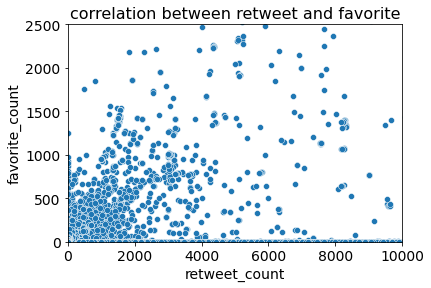

In [ ]:
visualize(x=pp_tweets.retweet_count, y=pp_tweets.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.xlim(0, 10000) 
plt.ylim(0, 2500) 
plt.show()

In [ ]:
pp_tweets[pp_tweets['retweet_count']<10000].retweet_count.corr(pp_tweets[pp_tweets['favorite_count']<2500].favorite_count)

0.0522694736631242

still no correlation found

In [ ]:
nz_favorite_count = pp_tweets[pp_tweets['favorite_count']>0].favorite_count
len(nz_favorite_count)

1951527

In [ ]:
nz_retweet_count = pp_tweets[pp_tweets['retweet_count']>0].retweet_count
len(nz_retweet_count)

2730753

In [ ]:
non_zeros = pd.merge(nz_favorite_count, nz_retweet_count, left_index=True, right_index=True)
len(non_zeros)

671882

In [ ]:
non_zeros.corr()

,favorite_count,retweet_count
favorite_count,1.00000,0.51274
retweet_count,0.51274,1.00000


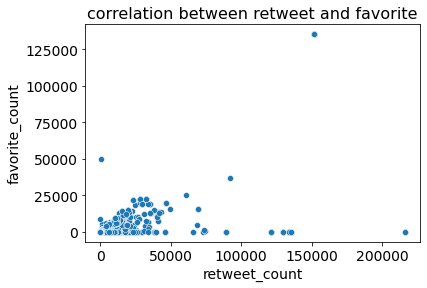

In [ ]:
visualize(x=non_zeros.retweet_count, y=non_zeros.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.show()

now that we considered just the non-zero values, we actually found some correlation. Anyway the plot does show some outlier values. We decide to cut just the points too far away.

In [ ]:
non_zeros[non_zeros['favorite_count']>5e4]

,favorite_count,retweet_count
1653221,135283.0,151541.0
1887228,135282.0,151540.0
4865056,50083.0,730.0
4979584,135293.0,151497.0
5028407,135299.0,151497.0
5094431,135292.0,151497.0
5152380,135293.0,151497.0
5255051,135299.0,151499.0
5376089,135299.0,151498.0
5685906,135291.0,151497.0


In [ ]:
len(non_zeros[non_zeros['favorite_count']>5e4])

38

In [ ]:
non_zeros.drop(non_zeros[non_zeros['favorite_count']>3e4].index, inplace=True)

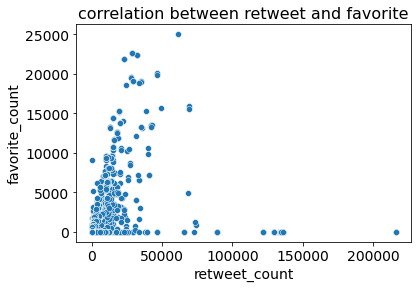

In [ ]:
visualize(x=non_zeros.retweet_count, y=non_zeros.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.show()

In [ ]:
non_zeros.corr()

,favorite_count,retweet_count
favorite_count,1.000000,0.229083
retweet_count,0.229083,1.000000


In [ ]:
non_zeros[non_zeros['retweet_count']>2e5]

,favorite_count,retweet_count
7770179,37.0,216217.0
9742041,37.0,216217.0


In [ ]:
non_zeros.drop(non_zeros[non_zeros['retweet_count']>2e5].index, inplace=True)

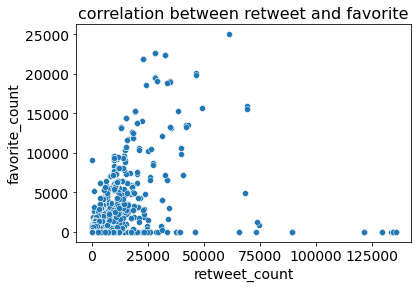

In [ ]:
visualize(x=non_zeros.retweet_count, y=non_zeros.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.show()

In [ ]:
non_zeros.corr()

,favorite_count,retweet_count
favorite_count,1.000000,0.232853
retweet_count,0.232853,1.000000


In [ ]:
non_zeros[non_zeros['retweet_count']>1e5]

,favorite_count,retweet_count
1653222,27.0,129464.0
1653223,21.0,121451.0
1653224,16.0,134258.0
1653245,39.0,135648.0
1887194,27.0,129463.0
...,...,...
9540719,39.0,135648.0
9604291,27.0,129465.0
9604292,21.0,121452.0
9604293,16.0,134258.0


In [ ]:
non_zeros.drop(non_zeros[non_zeros['retweet_count']>1e5].index, inplace=True)

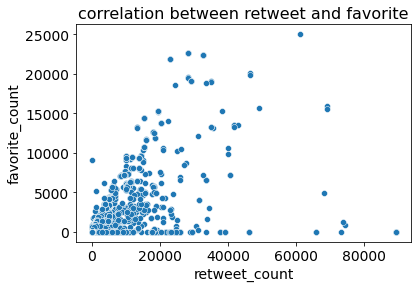

In [ ]:
visualize(x=non_zeros.retweet_count, y=non_zeros.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.show()

In [ ]:
non_zeros.corr()

,favorite_count,retweet_count
favorite_count,1.000000,0.583088
retweet_count,0.583088,1.000000


In [ ]:
non_zeros.drop(non_zeros[non_zeros['retweet_count']>6e4].index, inplace=True)

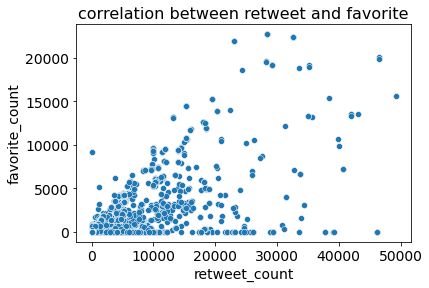

In [ ]:
visualize(x=non_zeros.retweet_count, y=non_zeros.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.show()

In [ ]:
non_zeros.corr()

,favorite_count,retweet_count
favorite_count,1.000000,0.748724
retweet_count,0.748724,1.000000


In [ ]:
non_zeros['ratio'] = non_zeros.retweet_count/non_zeros.favorite_count 

In [ ]:
non_zeros.describe()

,favorite_count,retweet_count,ratio
count,671675.000000,671675.000000,671675.000000
mean,15.214403,34.414787,4.281076
std,270.797477,609.734316,130.744091
min,1.000000,1.000000,0.000109
25%,1.000000,1.000000,0.500000
50%,2.000000,1.000000,1.000000
75%,4.000000,3.000000,1.000000
max,22683.000000,49244.000000,14715.500000


In [ ]:
non_zeros = pd.merge(nz_favorite_count, nz_retweet_count, left_index=True, right_index=True, how='outer')
len(non_zeros)

4010398

In [ ]:
non_zeros.fillna(0, inplace=True)

In [ ]:
non_zeros.corr()

,favorite_count,retweet_count
favorite_count,1.000000,0.033832
retweet_count,0.033832,1.000000


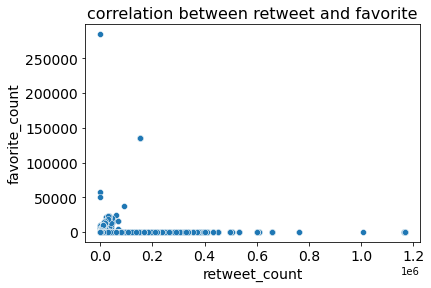

In [ ]:
visualize(x=non_zeros.retweet_count, y=non_zeros.favorite_count,
          xlabel='retweet_count', ylabel='favorite_count', 
          title='correlation between retweet and favorite', plot_type='scatter')
plt.show()

so, as seen above, we cannot consider zeros since they're going to obliterate our data

the process followed here is based on spotting outliers by the scatter plot, now it seems much better. Correlation is also higher.

Let's get more into this concept and analyze also the other numerical features.

In [ ]:
pp_tweets[['num_hashtags', 'num_mentions', 'num_urls']]

In [ ]:
nz_num_hashtags = pp_tweets[pp_tweets['num_hashtags']>0].num_hashtags
len(nz_num_hashtags)

1103286

In [ ]:
nz_num_mentions = pp_tweets[pp_tweets['num_mentions']>0].num_mentions
len(nz_num_mentions)

3972317

In [ ]:
nz_num_urls = pp_tweets[pp_tweets['num_urls']>0].num_urls
len(nz_num_urls)

1584241

In [ ]:
hashtags_mentions = pd.merge(nz_num_hashtags, nz_num_mentions, left_index=True, right_index=True)
len(hashtags_mentions)

587244

In [ ]:
hashtags_mentions_urls = pd.merge(hashtags_mentions, nz_num_urls, left_index=True, right_index=True)
len(hashtags_mentions_urls)

128805

In [ ]:
full_non_zeros = pd.merge(hashtags_mentions_urls, non_zeros, left_index=True, right_index=True)
len(full_non_zeros)

103452

In [ ]:
full_non_zeros.corr()

,num_hashtags,num_mentions,num_urls,favorite_count,retweet_count
num_hashtags,1.000000,-0.048083,-0.000704,-0.005974,-0.021062
num_mentions,-0.048083,1.000000,-0.021218,0.010092,-0.007104
num_urls,-0.000704,-0.021218,1.000000,-0.000076,0.003899
favorite_count,-0.005974,0.010092,-0.000076,1.000000,0.378172
retweet_count,-0.021062,-0.007104,0.003899,0.378172,1.000000


even though the set is so small, we can see that it seems there is no correlation amongst other features, beside retweet_count-favorite_count.

In [ ]:
a = len(pp_tweets[(pp_tweets["favorite_count"] == 0) & (pp_tweets["retweet_count"] > 1000)])
b = len(pp_tweets[pp_tweets["retweet_count"] > 1000])
print("Number of tweets with more than 1000 retweets:", b)
print("Number of tweets with more than 1000 retweets and at least 1 favorite: ", b-a)
print("Percentage of tweets with more of 1000 retweets which have 0 favorite: ", round(((b-a)/b)*100,3), end='')
print("%")

Number of tweets with more than 1000 retweets: 363416
Number of tweets with more than 1000 retweets and at least 1 favorite:  3369
Percentage of tweets with more of 1000 retweets which have 0 favorite:  0.927%


This is very strange, less than the 1% of tweets with more than 1000 retweets have at least 1 favorite.

### 1.2.4 NaN handling

In [ ]:
print("Tweets with null retweet_count:", len(pp_tweets[pp_tweets["retweet_count"].isnull()]))
print("Tweets with null favorite_count:", len(pp_tweets[pp_tweets["favorite_count"].isnull()]))
print("Tweets with null num_hashtags:", len(pp_tweets[pp_tweets["num_hashtags"].isnull()]))
print("Tweets with null num_urls:", len(pp_tweets[pp_tweets["num_urls"].isnull()]))
print("Tweets with null num_mentions:", len(pp_tweets[pp_tweets["num_mentions"].isnull()]))
print("Tweets with null text:", len(pp_tweets[pp_tweets["text"].isnull()]))
print("Tweets with at least one null field:", len(pp_tweets[pp_tweets["information_score"]>0]))

Tweets with null retweet_count: 0
Tweets with null favorite_count: 0
Tweets with null num_hashtags: 0
Tweets with null num_urls: 0
Tweets with null num_mentions: 0
Tweets with null text: 38036
Tweets with at least one null field: 38036


The only field with null values after the data cleaning is the text field. Let's see how many records have null text:

In [ ]:
print("Percentage of tweets with null text: ", round(((len(pp_tweets[pp_tweets["text"].isnull()]))/len(pp_tweets))*100, 3), end='')
print("%")

Percentage of tweets with null text:  0.388%


We drop them and then we drop also the information_score column:

In [ ]:
pp_tweets.drop((pp_tweets[pp_tweets["text"].isnull()]).index, inplace=True)

In [ ]:
pp_tweets.drop(columns="information_score", inplace=True)

### 1.2.5 Ratio

In [ ]:
pp_tweets['ratio'] = (pp_tweets[pp_tweets['retweet_count']>0].retweet_count/pp_tweets.favorite_count).replace([np.inf, -np.inf], np.nan)

visualizing some plots

In [ ]:
ratio_nn = pp_tweets[~pp_tweets['ratio'].isna()]

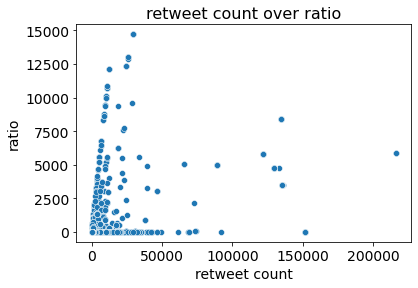

In [ ]:
visualize(x=ratio_nn.retweet_count, y=ratio_nn.ratio, plot_type='scatter',
         xlabel='retweet count', ylabel='ratio', title='retweet count over ratio')
plt.show()

In [ ]:
ratio_nn.retweet_count.corr(ratio_nn.ratio)

0.525358528000542

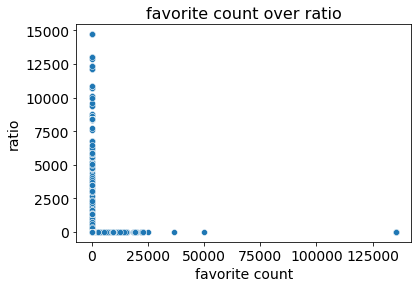

In [ ]:
visualize(x=ratio_nn.favorite_count, y=ratio_nn.ratio, plot_type='scatter',
         xlabel='favorite count', ylabel='ratio', title='favorite count over ratio')
plt.show()

In [ ]:
ratio_nn.favorite_count.corr(ratio_nn.ratio)

-0.0003324928577801797

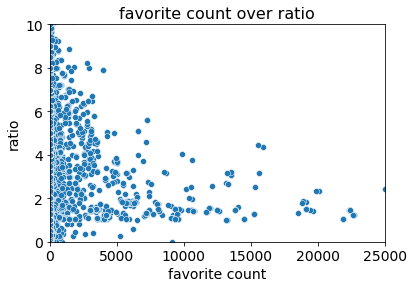

In [ ]:
visualize(x=ratio_nn.favorite_count, y=ratio_nn.ratio, plot_type='scatter',
         xlabel='favorite count', ylabel='ratio', title='favorite count over ratio')
plt.xlim(0,25000)
plt.ylim(0,10)
plt.show()

### 1.2.4* Dump

In [ ]:
#save
#pp_tweets.to_csv(basepath+"/pp_tweets_checkpoint_1.2.4.csv")

In [ ]:
#load
pp_tweets = pd.read_csv(basepath + '/pp_tweets_checkpoint_1.2.4.csv', lineterminator='\n', index_col=0, parse_dates=['created_at'])

### 1.2.5 Metrics by user

#### 1.2.5.1 Tweets per user

Now, we want to take a look at how much tweets each user have.
First, just look at the average of tweets per user just by dividing the number of tweets by the number of different users:

In [ ]:
len(pp_tweets.user_id.unique())

11504

In [ ]:
len(pp_tweets)/len(pp_tweets.user_id.unique())

849.8116307371349

Now we go more in details; in order to do this, we group the tweets by user with "count" as aggregating function

In [ ]:
grouped_users = pp_tweets.groupby(['user_id'])['user_id'].count().reset_index(name='tweets')

So we can now see the distribution of tweets per user:

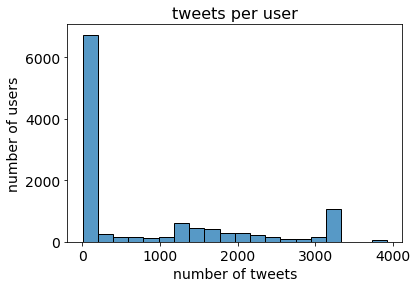

In [ ]:
visualize(data=grouped_users['tweets'], plot_type='hist', bins=20,
          xlabel='number of tweets', ylabel='number of users', title='tweets per user')
plt.show()

bins:  [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500, 3000, 3500]


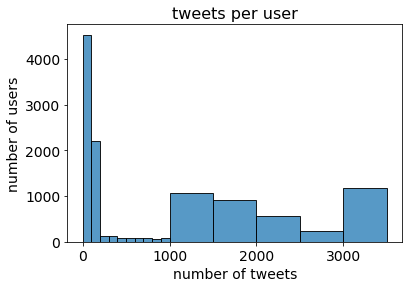

In [ ]:
bins = [x for x in range(0, 1000, 100)] + [x for x in range(1000, grouped_users.tweets.max(), 500)]
print("bins: ", bins)
visualize(data=grouped_users['tweets'], plot_type='hist', bins=bins,
          xlabel='number of tweets', ylabel='number of users', title='tweets per user')
plt.show()

We can see that the majority part of users have a small number of tweets (at most some hundreds), while there is a non-negligible part of users with thousands of tweets. Are them bots? We will analyze this hypothesis later, when we join the datasets Users and Tweets.

Now, let's see a boxplot of the number of tweets per user, so we can see better if there is some outlier

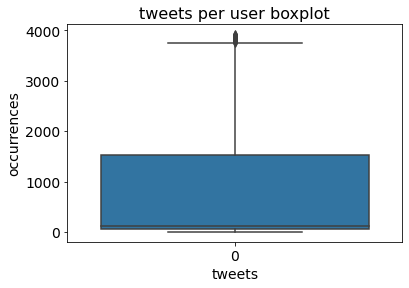

In [ ]:
visualize(data=grouped_users.tweets, plot_type='boxplot',
          xlabel='tweets', ylabel='occurrences', title='tweets per user boxplot')
plt.show()

As we can see, the distribution is not too spread, we have some outliers near to Q3+$\frac{3}{2}$IQR. Moreover, we can notice that the median is low, very near to Q1 and that the boxplot is shifted down (as we can imagine from the plot above). No obvious otliers here.

#### 1.2.5.2 Counts per user

We want to analyze the counters ('retweet count' and 'favourite_count') for each user, so we proceed with a new groupby

In [ ]:
gb_retweet = pp_tweets.groupby(['user_id'])['retweet_count'].sum().reset_index(name='retweets')
gb_favorite = pp_tweets.groupby(['user_id'])['favorite_count'].sum().reset_index(name='favorites')

In [ ]:
gb_retweet.retweets.max(), gb_favorite.favorites.max()

(91573952.0, 830445.0)

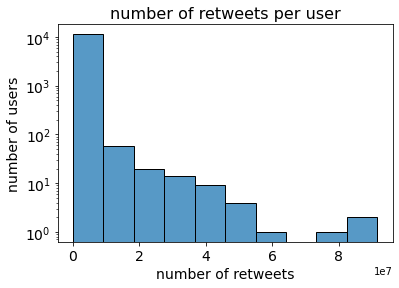

In [ ]:
visualize(data=gb_retweet['retweets'], plot_type='hist', bins=10, log_scale=(False, True),
          xlabel='number of retweets', ylabel='number of users', title='number of retweets per user')

plt.rcParams["patch.force_edgecolor"] = True
plt.show()

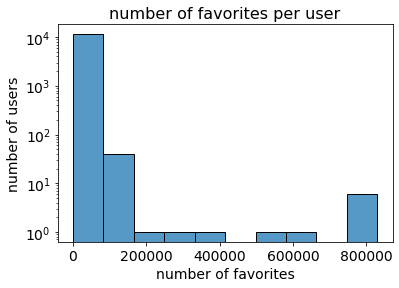

In [ ]:
visualize(data=gb_favorite['favorites'], plot_type='hist', bins=10, log_scale=(False, True),
          xlabel='number of favorites', ylabel='number of users', title='number of favorites per user')

plt.rcParams["patch.force_edgecolor"] = True
plt.show()

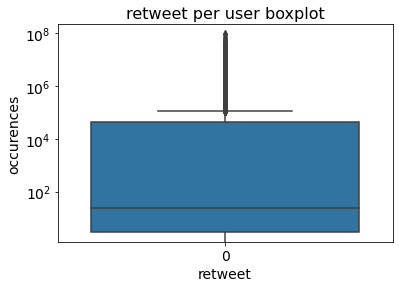

In [ ]:
visualize(data=gb_retweet.retweets, plot_type='boxplot',
          xlabel='retweet', ylabel='occurences', title='retweet per user boxplot')
plt.yscale('log')
plt.show()

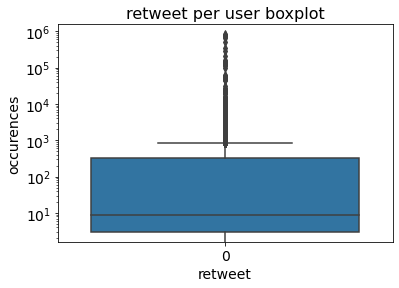

In [ ]:
visualize(data=gb_favorite.favorites, plot_type='boxplot',
          xlabel='favorites', ylabel='occurences', title='retweet per user boxplot')
plt.yscale('log')
plt.show()

We see a lot of outliers. However, this is quite normal since there can be active users with a lot of followers with very high stats, while the majority of users have very little interactions.


#### 1.2.5.3 Statistics by user

We want to look at the std and the mean of the number of favorites and retweets of each user

In [ ]:
gb_fav_std = pp_tweets.groupby(['user_id'])['favorite_count'].std().reset_index(name='fav_std')
gb_rtw_std = pp_tweets.groupby(['user_id'])['retweet_count'].std().reset_index(name='rtw_std')
gb_fav_max = pp_tweets.groupby(['user_id'])['favorite_count'].max().reset_index(name='fav_max')
gb_rtw_max = pp_tweets.groupby(['user_id'])['retweet_count'].max().reset_index(name='rtw_max')

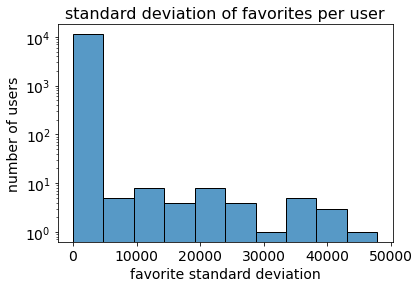

In [ ]:
visualize(data=gb_fav_std['fav_std'], plot_type='hist', bins=10, log_scale=(False, True),
          xlabel='favorite standard deviation', ylabel='number of users', title='standard deviation of favorites per user')

plt.rcParams["patch.force_edgecolor"] = True
plt.show()

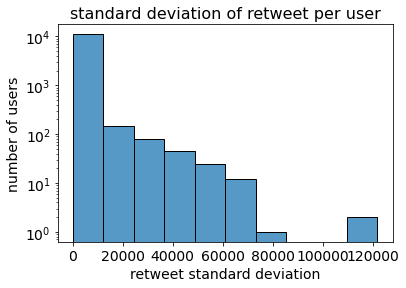

In [ ]:
visualize(data=gb_rtw_std['rtw_std'], plot_type='hist', bins=10, log_scale=(False, True),
          xlabel='retweet standard deviation', ylabel='number of users', title='standard deviation of retweet per user')

plt.rcParams["patch.force_edgecolor"] = True
plt.show()


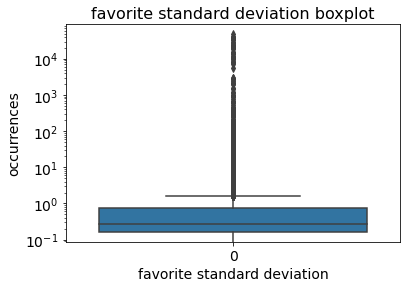

In [ ]:
visualize(data= gb_fav_std.fav_std, plot_type='boxplot', xlabel='favorite standard deviation', 
          ylabel='occurrences', title='favorite standard deviation boxplot')
plt.yscale('log')
plt.show()

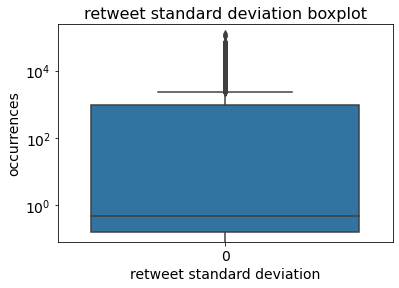

In [ ]:
visualize(data=gb_rtw_std.rtw_std, plot_type='boxplot', xlabel='retweet standard deviation', 
          ylabel='occurrences', title='retweet standard deviation boxplot')
plt.yscale('log')
plt.show()

In [ ]:
df_merge = grouped_users.merge(gb_favorite.merge(gb_retweet, on='user_id'), on='user_id')

In [ ]:
df_merge = df_merge.merge(gb_fav_std, on='user_id')
df_merge = df_merge.merge(gb_rtw_std, on='user_id')
df_merge = df_merge.merge(gb_fav_max, on='user_id')
df_merge = df_merge.merge(gb_rtw_max, on='user_id')

In [ ]:
df_merge["fav_mean"] = df_merge["favorites"]/df_merge["tweets"]
df_merge["rtw_mean"] = df_merge["retweets"]/df_merge["tweets"]

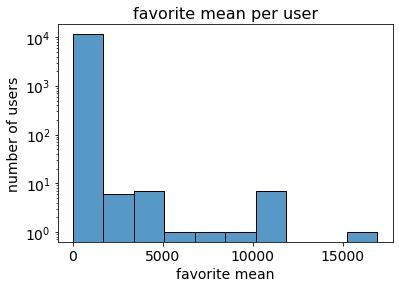

In [ ]:
visualize(data=df_merge['fav_mean'], plot_type='hist', bins=10, log_scale=(False, True),
          xlabel='favorite mean', ylabel='number of users', title='favorite mean per user')

plt.rcParams["patch.force_edgecolor"] = True
plt.show()

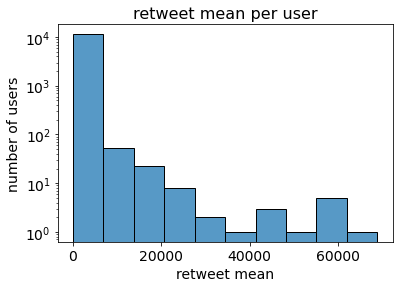

In [ ]:
visualize(data=df_merge['rtw_mean'], plot_type='hist', bins=10, log_scale=(False, True),
          xlabel='retweet mean', ylabel='number of users', title='retweet mean per user')

plt.rcParams["patch.force_edgecolor"] = True
plt.show()

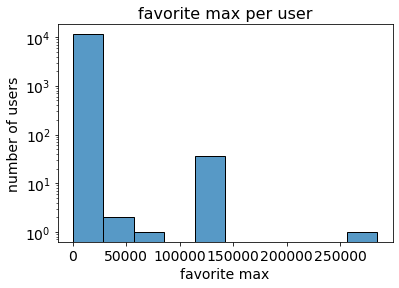

In [ ]:
visualize(data=df_merge['fav_max'], plot_type='hist', bins=10, log_scale=(False, True),
          xlabel='favorite max', ylabel='number of users', title='favorite max per user')

plt.rcParams["patch.force_edgecolor"] = True
plt.show()

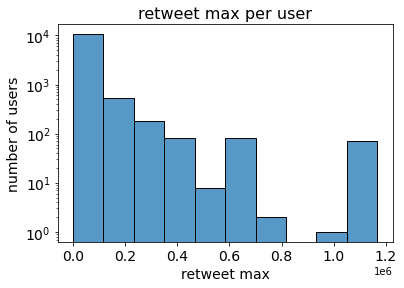

In [ ]:
visualize(data=df_merge['rtw_max'], plot_type='hist', bins=10, log_scale=(False, True),
          xlabel='retweet max', ylabel='number of users', title='retweet max per user')

plt.rcParams["patch.force_edgecolor"] = True
plt.show()

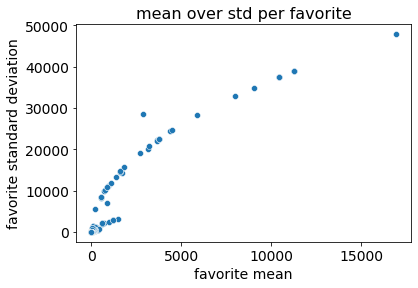

In [ ]:
visualize(x=df_merge.fav_mean, y=df_merge.fav_std, plot_type='scatter',
          xlabel='favorite mean', ylabel='favorite standard deviation', title='mean over std per favorite')
plt.show()

In [ ]:
df_merge.fav_mean.corr(df_merge.fav_std)

0.9501100781750641

and, as we expect they are highly correlated. 

Still, there are some outliers, we might want to remove

In [ ]:
df_merge[(df_merge['fav_mean'] < 5000) & (df_merge['fav_std'] > 27000)]

,user_id,tweets,favorites,retweets,fav_std,rtw_std,fav_max,rtw_max,fav_mean,rtw_mean
10471,2381120330,99,284906.0,4.0,28633.419675,0.197907,284899.0,1.0,2877.838384,0.040404


In [ ]:
df_merge.drop(df_merge[(df_merge['fav_mean'] < 5000) & (df_merge['fav_std'] > 27000)].index, inplace=True)

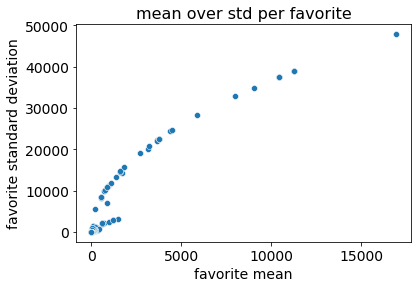

In [ ]:
visualize(x=df_merge.fav_mean, y=df_merge.fav_std, plot_type='scatter',
          xlabel='favorite mean', ylabel='favorite standard deviation', title='mean over std per favorite')
plt.show()

In [ ]:
df_merge.fav_mean.corr(df_merge.fav_std)

0.9554794242853984

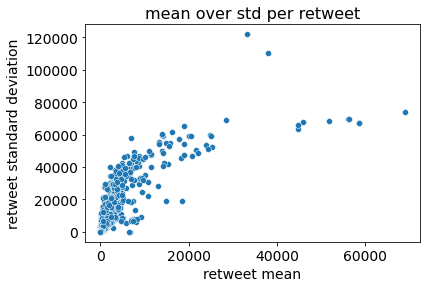

In [ ]:
visualize(x=df_merge.rtw_mean, y=df_merge.rtw_std, plot_type='scatter',
          xlabel='retweet mean', ylabel='retweet standard deviation', title='mean over std per retweet')
plt.show()

In [ ]:
df_merge.rtw_mean.corr(df_merge.rtw_std)

0.7859921905456608

Also here, some outliers are present.

In [ ]:
df_merge[(df_merge['rtw_mean'] > 30000) & (df_merge['rtw_std'] > 100000)]

,user_id,tweets,favorites,retweets,fav_std,rtw_std,fav_max,rtw_max,fav_mean,rtw_mean
905,104960620,213,39.0,7066096.0,1.796038,121921.531354,26.0,1166116.0,0.183099,33174.159624
11055,2467442030,35,4.0,1330525.0,0.322803,110310.595338,1.0,401304.0,0.114286,38015.000000


In [ ]:
df_merge.drop(df_merge[(df_merge['rtw_mean'] > 30000) & (df_merge['rtw_std'] > 100000)].index, inplace=True)

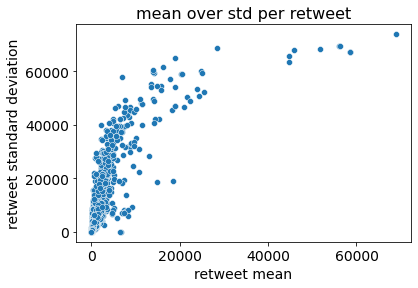

In [ ]:
visualize(x=df_merge.rtw_mean, y=df_merge.rtw_std, plot_type='scatter',
          xlabel='retweet mean', ylabel='retweet standard deviation', title='mean over std per retweet')
plt.show()

In [ ]:
df_merge.rtw_mean.corr(df_merge.rtw_std)

0.7740118985825493

#### 1.2.5.4 Ratios per user

We want to take a look at the relations between number of tweets, favorites and retweets of the users. Let's start with favorites and retweets:

In [ ]:
df_merge.head()

,user_id,tweets,favorites,retweets,fav_std,rtw_std,fav_max,rtw_max,fav_mean,rtw_mean
0,678033,2372,1201.0,187144.0,1.420300,723.977384,34.0,21325.0,0.506324,78.897133
1,722623,2021,969.0,1158520.0,1.078686,11511.057984,19.0,296689.0,0.479466,573.240970
2,755116,2144,391.0,92396.0,0.490552,546.756694,8.0,13121.0,0.182369,43.095149
3,755746,2017,209.0,317861.0,0.392984,3360.189367,7.0,105138.0,0.103619,157.590977
4,785080,3433,1712.0,138486.0,1.167529,463.009623,32.0,16181.0,0.498689,40.339645


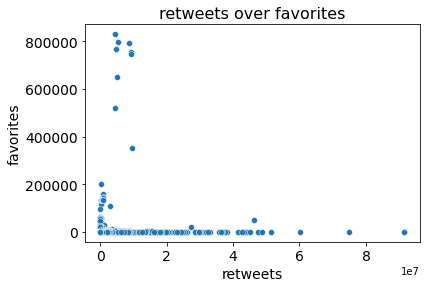

In [ ]:
visualize(x=df_merge.retweets, y=df_merge.favorites, plot_type='scatter',
          xlabel='retweets', ylabel='favorites', title='retweets over favorites')
plt.show()

it seems there are some high values that might be considered outliers

In [ ]:
df_merge[df_merge['favorites'] > 3e5]

,user_id,tweets,favorites,retweets,fav_std,rtw_std,fav_max,rtw_max,fav_mean,rtw_mean
393,37384589,640,766672.0,4753603.0,2800.065804,8160.670087,22683.0,61161.0,1197.925000,7427.504687
694,72110028,1120,791755.0,8661563.0,2188.490725,7532.442437,22683.0,61161.0,706.924107,7733.538393
764,82885728,568,830445.0,4496472.0,3004.672033,7880.588224,22667.0,46559.0,1462.051056,7916.323944
941,110120789,535,522180.0,4354265.0,2500.370630,6859.978918,20094.0,69142.0,976.037383,8138.813084
1736,252647855,539,650902.0,4954900.0,2938.370292,9221.050502,25019.0,69142.0,1207.610390,9192.764378
1880,290499654,1360,353909.0,9499984.0,1234.751121,7066.172716,22381.0,61161.0,260.227206,6985.282353
2200,349392750,1321,757333.0,9268184.0,2006.912705,7011.945752,22661.0,61161.0,573.302801,7016.036336
2282,370098498,657,799341.0,5460960.0,2765.920961,8143.023319,22661.0,61161.0,1216.652968,8311.963470
3244,475732319,1231,748225.0,9194201.0,2066.307244,6929.205455,22661.0,61161.0,607.818846,7468.887896


they are a small number, and they do not seem to develop a pattern whatsoever

In [ ]:
df_merge.drop(df_merge[df_merge['favorites'] > 3e5].index, inplace=True)

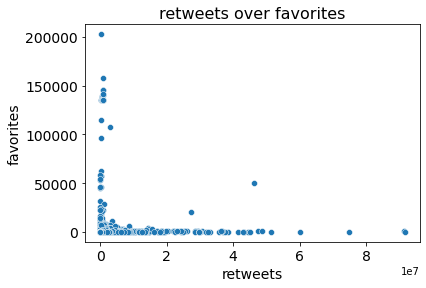

In [ ]:
visualize(x=df_merge.retweets, y=df_merge.favorites, plot_type='scatter',
          xlabel='retweets', ylabel='favorites', title='retweets over favorites')
plt.show()

it seems there are two predominant patterns here:
- one made of user with more retweets than favorites (most of favorites are close to zero)
- one made of user with more favorites than retweets (most of retweets are close to zero)

In [ ]:
df_merge[(df_merge['retweets'] > 2e7) & (df_merge['favorites'] > 10000)]

,user_id,tweets,favorites,retweets,fav_std,rtw_std,fav_max,rtw_max,fav_mean,rtw_mean
2422,402401015,3139,20171.0,27477985.0,43.082559,46574.89522,1046.0,1166102.0,6.425932,8753.738452
7240,1947320929,2958,50256.0,46393106.0,920.854391,53065.61714,50083.0,657364.0,16.989858,15683.943881


In [ ]:
df_merge.drop(df_merge[(df_merge['retweets'] > 2e7) & (df_merge['favorites'] > 10000)].index, inplace=True)

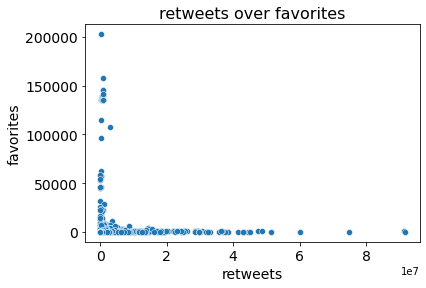

In [ ]:
visualize(x=df_merge.retweets, y=df_merge.favorites, plot_type='scatter',
          xlabel='retweets', ylabel='favorites', title='retweets over favorites')
plt.show()

In [ ]:
df_merge[df_merge['retweets'] > 5.8e7]

,user_id,tweets,favorites,retweets,fav_std,rtw_std,fav_max,rtw_max,fav_mean,rtw_mean
1219,159691975,3667,754.0,91418055.0,1.945869,60024.114325,98.0,1165198.0,0.205618,24929.930461
1585,231211273,3176,379.0,60058978.0,1.172355,54293.540626,40.0,1165422.0,0.119332,18910.257557
3678,552147716,2992,314.0,74885749.0,0.762075,59359.835467,30.0,657401.0,0.104947,25028.659425
7302,2193114259,3219,288.0,91573952.0,0.560296,68757.822383,16.0,1165276.0,0.089469,28447.950295


In [ ]:
df_merge.drop(df_merge[df_merge['retweets'] > 5.8e7].index, inplace=True)

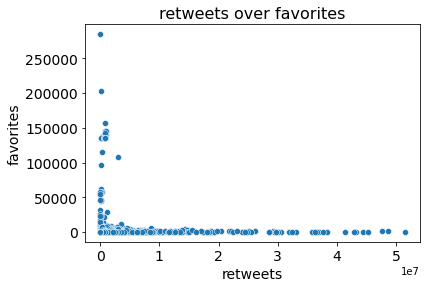

In [ ]:
visualize(x=df_merge.retweets, y=df_merge.favorites, plot_type='scatter',
          xlabel='retweets', ylabel='favorites', title='retweets over favorites')
plt.show()

now it seems more legit

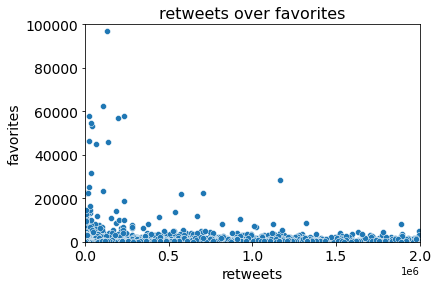

In [ ]:
visualize(x=df_merge.retweets, y=df_merge.favorites, plot_type='scatter',
          xlabel='retweets', ylabel='favorites', title='retweets over favorites')
plt.xlim(0,0.2e7)
plt.ylim(0,1e5)
plt.show()

even looking closer, it seems there is no linear correlation

In [ ]:
df_merge['retw_over_fav'] = df_merge.retweets/df_merge.favorites

Let's now see if there is a relation between number of tweets and retwees:

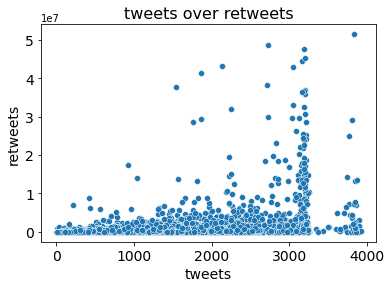

In [ ]:
visualize(x=df_merge.tweets, y=df_merge.retweets, plot_type='scatter',
          xlabel='tweets', ylabel='retweets', title='tweets over retweets')
plt.show()

this scatter seems hard to interpret. We can observe that when tweets grow up, retweets do the same. Although there are some values that may be not so well put, it is pretty hard to be sure they represent real outliers.

In [ ]:
df_merge['tw_over_retw'] = df_merge.tweets/df_merge.retweets

Let's see the last one: tweets and favorites:

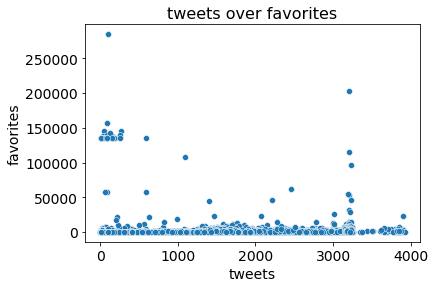

In [ ]:
visualize(x=df_merge.tweets, y=df_merge.favorites, plot_type='scatter',
          xlabel='tweets', ylabel='favorites', title='tweets over favorites')
plt.show()

In [ ]:
df_merge[df_merge['favorites'] > 1.7e5]

,user_id,tweets,favorites,retweets,fav_std,rtw_std,fav_max,rtw_max,fav_mean,rtw_mean,retw_over_fav,tw_over_retw
3728,564249598,3206,202819.0,174269.0,37.040090,41.301842,465.0,776.0,63.262321,54.357143,0.859234,0.018397
10471,2381120330,99,284906.0,4.0,28633.419675,0.197907,284899.0,1.0,2877.838384,0.040404,0.000014,24.750000


In [ ]:
df_merge.drop(df_merge[df_merge['favorites'] > 1.7e5].index, inplace=True)

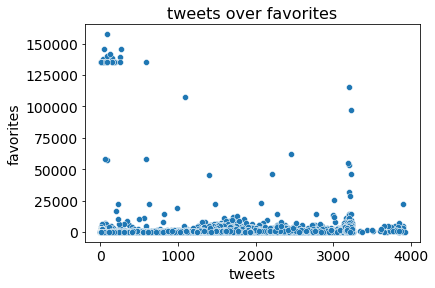

In [ ]:
visualize(x=df_merge.tweets, y=df_merge.favorites, plot_type='scatter',
          xlabel='tweets', ylabel='favorites', title='tweets over favorites')
plt.show()

definitely a strange scatter. There seem to be some outliers here, but it might not be easy to find them

In [ ]:
len(df_merge[(df_merge['favorites'] > 1e5) & (df_merge['tweets'] < 1000)])

37

even if this group represent a close-to-zero percentage of the dataset, it could carry some useful information for later on analysis. 

In [ ]:
df_merge['tw_over_fav'] = df_merge.tweets/df_merge.favorites

#### 1.2.5.5 Tweets per user in periods of time
In the following part, we're going to analyze the user's activity based on different periods of time

In [ ]:
grp_metrics = pd.DataFrame(pp_users.index).set_index("id")

In [ ]:
#let's define a function which tell us the day period of the tweet
def day_period(hour_of_day):
  day_slices = {'morning': 6, 'afternoon': 12, 'evening': 18, 'night': 24}
  if hour_of_day < day_slices.get('afternoon') and hour_of_day >= day_slices.get('morning'):
    return 'tw_morning'
  elif hour_of_day <= day_slices.get('evening') and hour_of_day >= day_slices.get('afternoon'):
    return 'tw_afternoon'
  elif hour_of_day < day_slices.get('night') and hour_of_day >= day_slices.get('evening'):
    return 'tw_evening'
  elif hour_of_day < day_slices.get('morning') and hour_of_day >= day_slices.get('night')%24:
    return 'tw_night'

In [ ]:
tweets_day_period = pp_tweets.created_at.apply(lambda x: day_period(x.hour))

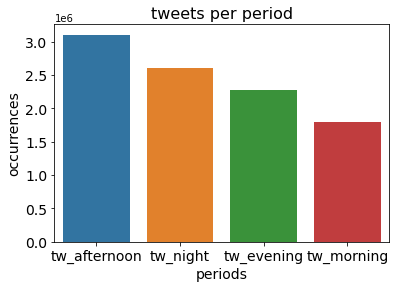

In [ ]:
visualize(x=tweets_day_period.value_counts().index, y=tweets_day_period.value_counts().values, 
          plot_type='barplot', xlabel='periods', ylabel='occurrences', title='tweets per period')
plt.show()

... this is the distribution based on all tweets. Now let's look at it based on the user

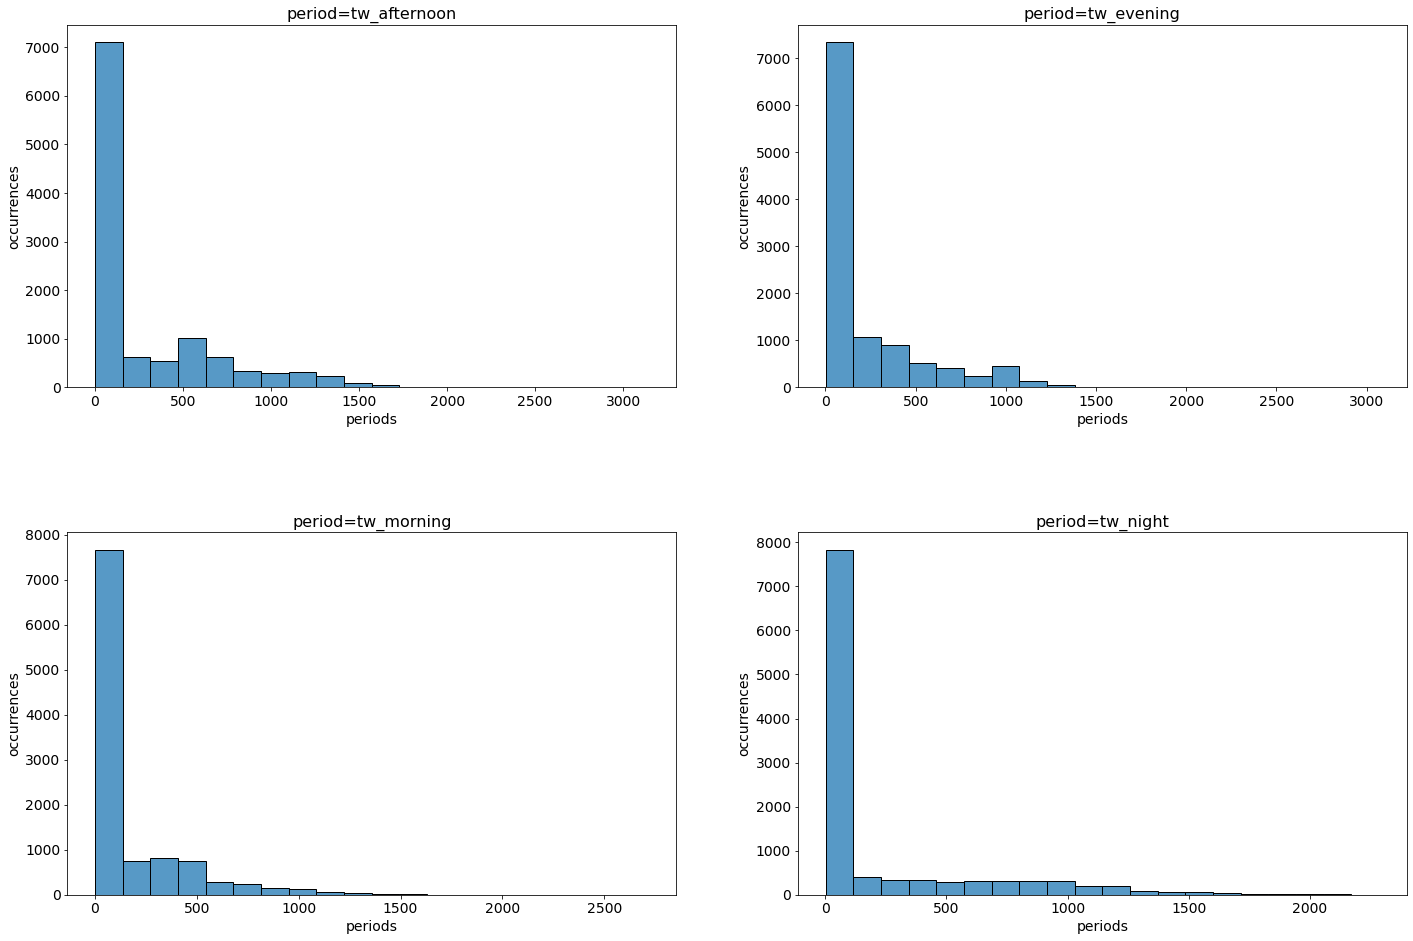

In [ ]:
grouped = pp_tweets.groupby(tweets_day_period)
rowlength = int(grouped.ngroups/2)
fig, axs = plt.subplots(figsize=(24,16), 
                        nrows=2, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
  group = grouped.get_group(key)

  to_push = pd.DataFrame(group.user_id.value_counts()).rename(columns={"user_id":key})
  grp_metrics = pd.merge(grp_metrics,to_push,left_index=True,right_index=True, how="outer")

  visualize(data=group.user_id.value_counts(), plot_type='hist', ax=ax, bins=20)
  ax.set_title('period=%s'%key, fontsize=16)
  ax.set_xlabel('periods', fontsize=14)
  ax.set_ylabel('occurrences', fontsize=14)
  ax.tick_params(axis='both', which='major', labelsize=14)
    
plt.show()

looking at the histograms we can see that they all look the same. This could be motivated by the fact we do not have timezones, hence we do not know how users are distributed around the globe and, for this reason, we might have information who are not "uniformed". This may be an explanation on what is happening in the above plots.


Now let's look at years' statistics. How many tweets did the users make each year?

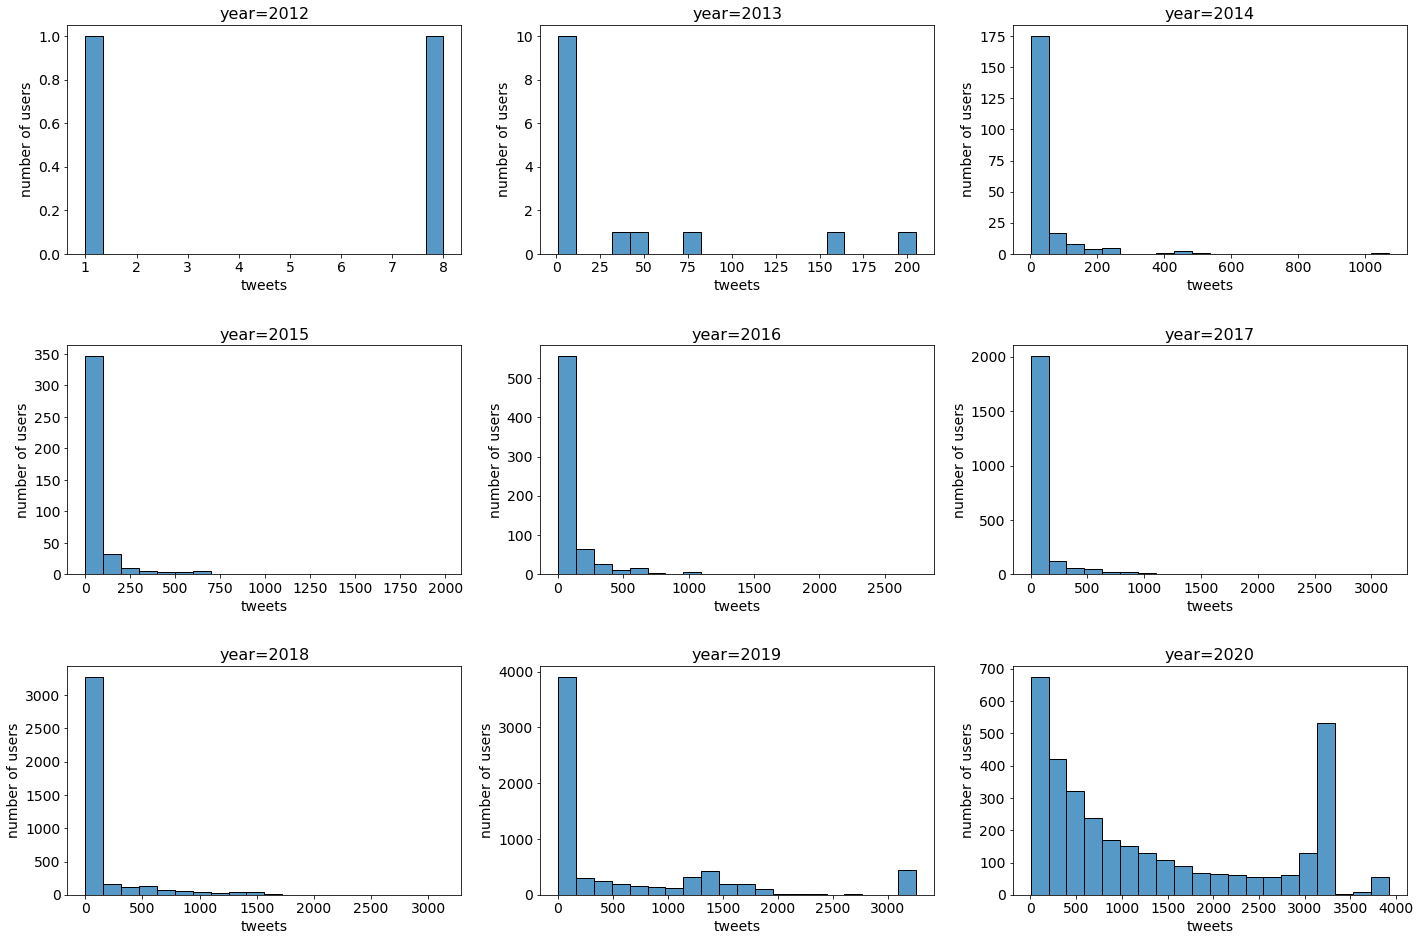

In [ ]:
all_years = pp_tweets.created_at.apply(lambda x: int(x.year))
grouped = pp_tweets.groupby(all_years)

rowlength = int(grouped.ngroups/3)
fig, axs = plt.subplots(figsize=(24,16), 
                        nrows=3, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
  group = grouped.get_group(key)

  to_push = pd.DataFrame(group.user_id.value_counts()).rename(columns={"user_id":"tw_"+str(key)})
  grp_metrics = pd.merge(grp_metrics,to_push,left_index=True,right_index=True, how="outer")

  visualize(data=group.user_id.value_counts(), plot_type='hist', ax=ax, bins=20)
  ax.set_title('year=%s'%key, fontsize=16)
  ax.set_xlabel('tweets', fontsize=14)
  ax.set_ylabel('number of users', fontsize=14)
  ax.tick_params(axis='both', which='major', labelsize=14)
    
plt.show()

In [ ]:
grp_metrics.fillna(0,inplace=True)

filling nan with 0 since they all represent the number of tweets in a selected period of time.

... in the above histograms we can see the yearly tweets-per_user distribution.

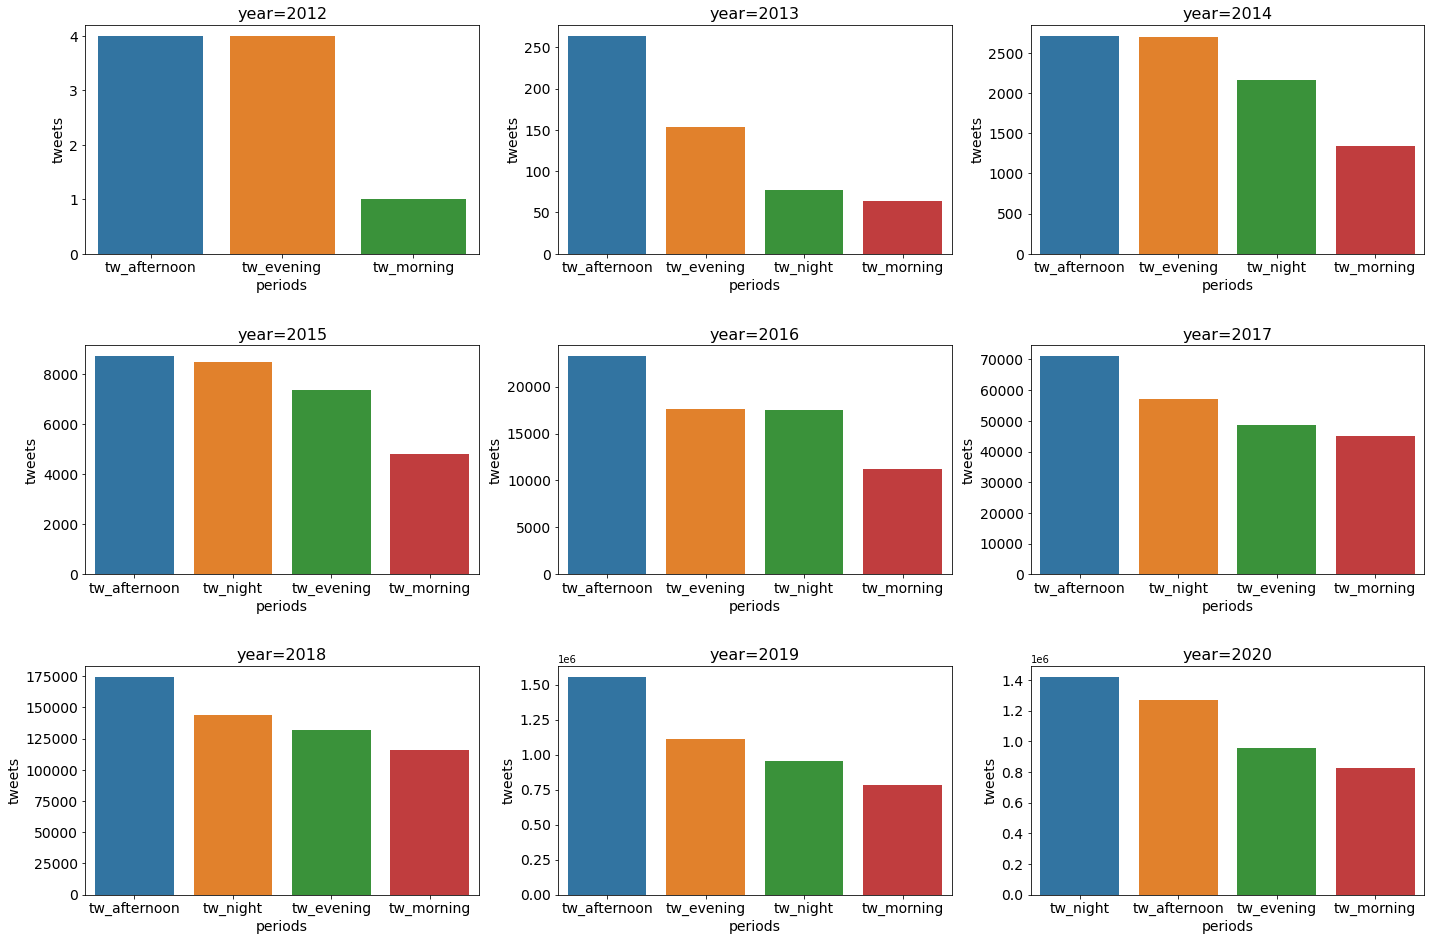

In [ ]:
all_years = pp_tweets.created_at.apply(lambda x: int(x.year))
grouped = pp_tweets.groupby(all_years)

rowlength = int(grouped.ngroups/3)
fig, axs = plt.subplots(figsize=(24,16), 
                        nrows=3, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
  group = grouped.get_group(key)
  group_tweets_period = group.created_at.apply(lambda x: day_period(x.hour))
    
  
  visualize(x=group_tweets_period.value_counts().index, y=group_tweets_period.value_counts().values,
            plot_type='barplot', ax=ax)
  ax.set_title('year=%d'%key, fontsize=16)
  ax.set_xlabel('periods', fontsize=14)
  ax.set_ylabel('tweets', fontsize=14)
  ax.tick_params(axis='both', which='major', labelsize=14)
    
plt.show() 

... and also, how many tweets have been made each year with regard to the time periods taken.
We notice that every year seems to be pretty similar to each other. Afternoon is the most active time, and morning the least one.

#### 1.2.5.6 Average number of special characters per user's tweets
Now let's look at another metric: the number of special characters per users' tweets.

we can start by dropping all those rows where there's no text (text column is nan)

In [ ]:
pp_tweets.text.isna().value_counts()

False    9776233
Name: text, dtype: int64

In [ ]:
pp_tweets.dropna(subset=['text'], inplace=True)

In [ ]:
users_groups = pp_tweets.groupby('user_id')

In [ ]:
import re

def count_special_chars(query):
  query = ''.join(query.split())
  return len(re.findall(r'\W', query))

In [ ]:
avg_per_user = dict()
for key in users_groups.groups.keys():
  group = users_groups.get_group(key)
  sum = group.text.apply(lambda x: count_special_chars(x)).sum()
  n_tweets = len(group)
  avg = sum/n_tweets
  avg_per_user[key] = avg

In [ ]:
schar = pd.DataFrame.from_dict(avg_per_user,orient="index").rename(columns={0:"avg_schar"})

In [ ]:
len(avg_per_user)-len(grp_metrics)

0

In [ ]:
# we use inner because we have 5 users for which all the relative tweets were dropped by the prepocessing phase
grp_metrics = pd.merge(grp_metrics,schar,left_index=True,right_index=True)

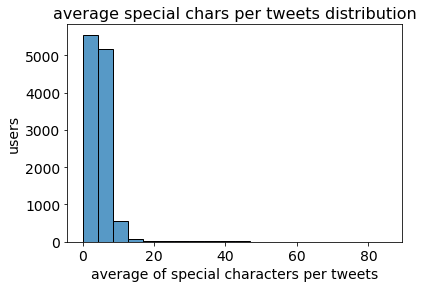

In [ ]:
visualize(data=avg_per_user, plot_type='hist', bins=20, xlabel='average of special characters per tweets', 
          ylabel='users', title='average special chars per tweets distribution')
plt.show()

... as we can see, most of the users have low average value of special characters per tweet 

In [ ]:
grp_metrics.avg_schar

678033        6.900084
722623        5.935675
755116        4.966418
755746        6.564700
785080        5.627731
                ...   
3150545196    2.813953
3154356636    6.596059
3158349782    5.791667
3159993463    6.691589
3161171948    5.333333
Name: avg_schar, Length: 11504, dtype: float64

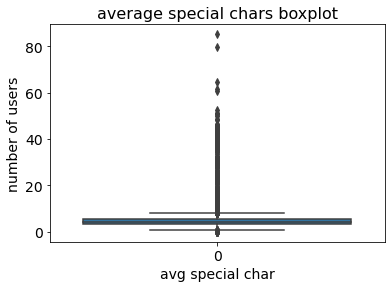

In [ ]:
visualize(data=list(avg_per_user.values()), plot_type='boxplot', 
          xlabel='avg special char', ylabel='number of users', title='average special chars boxplot')
plt.show()

based on the ditribution we have, it is pretty expected to visualize such a boxplot.

In [ ]:
avg_values = list(avg_per_user.values())
percentiles = np.quantile(avg_values, [0.5, 0.75, 0.9])
p90th = percentiles[2]
print(percentiles)

[4.34704225 5.37965977 7.60286232]


we have pretty standard values. Those which might be higher can be representative of users that do use lots of emojis, or non-ascii characters, such as chinese alphabets.

Thus, we cannot identify outliers for this specific metric.

### 1.2.6 Pushing tweet metrics to users dataset

In [ ]:
df_merge = pd.merge(df_merge,grp_metrics, left_on="user_id",right_index=True)

In [ ]:
df_merge.keys()

Index(['user_id', 'tweets', 'favorites', 'retweets', 'fav_std', 'rtw_std',
       'fav_max', 'rtw_max', 'fav_mean', 'rtw_mean', 'retw_over_fav',
       'tw_over_retw', 'tw_over_fav', 'tw_afternoon', 'tw_evening',
       'tw_morning', 'tw_night', 'tw_2012', 'tw_2013', 'tw_2014', 'tw_2015',
       'tw_2016', 'tw_2017', 'tw_2018', 'tw_2019', 'tw_2020', 'avg_schar'],
      dtype='object')

#### 1.2.6* Dump metrics dataset

In [ ]:
#save
df_merge.to_csv(basepath+"/users_merge_1.csv")

In [ ]:
#load
users_metrics = pd.read_csv(basepath + '/users_merge_1.csv', lineterminator='\n').set_index('user_id').drop(columns=['Unnamed: 0'])

#### 1.2.6.** Users' info merge and dump

In [ ]:
users_full = pd.merge(pp_users, users_metrics, left_index=True, right_on='user_id')

In [ ]:
users_full.keys()

Index(['lang', 'bot', 'created_at', 'statuses_count', 'st_per_day', 'tweets',
       'favorites', 'retweets', 'fav_std', 'rtw_std', 'fav_max', 'rtw_max',
       'fav_mean', 'rtw_mean', 'retw_over_fav', 'tw_over_retw', 'tw_over_fav',
       'tw_afternoon', 'tw_evening', 'tw_morning', 'tw_night', 'tw_2012',
       'tw_2013', 'tw_2014', 'tw_2015', 'tw_2016', 'tw_2017', 'tw_2018',
       'tw_2019', 'tw_2020', 'avg_schar'],
      dtype='object')

In [ ]:
#save
users_full.to_csv(basepath+"/users_full_1.csv")

In [ ]:
#load
users_full = pd.read_csv(basepath + '/users_full_1.csv', lineterminator='\n', index_col=0, parse_dates=['created_at'])

## 1.3 Merging datasets' information


In [ ]:
users_full.rename(columns={"created_at": "sign_up_date"}, inplace=True)

In [ ]:
pp_tweets.rename(columns={"created_at": "tweet_date"}, inplace=True)

Starting from the user last activity value, i.e. the last tweet found for each user

In [ ]:
last_activity = pp_tweets.groupby('user_id').tweet_date.max()

In [ ]:
users_full = users_full.merge(last_activity, left_index=True, right_index=True)

In [ ]:
users_full.rename(columns={"tweet_date": "last_activity"}, inplace=True)

### 1.3.1 Average tweets per month by user

#### 1.3.1.1 Activity period

The activity lifespan is here defined as the time delta between the user's sign_up_date and the user's last tweet:

In [ ]:
users_full['activity_period'] = (users_full.last_activity - users_full.sign_up_date).dt.ceil('d').dt.days

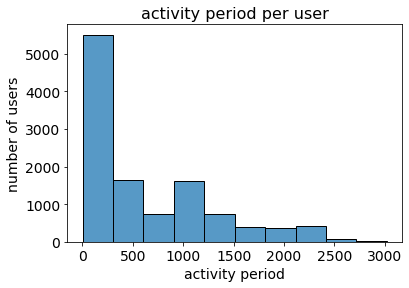

In [ ]:
visualize(data=users_full.activity_period, plot_type='hist', bins=10,
          xlabel='activity period', ylabel='number of users', title='activity period per user')
plt.show()

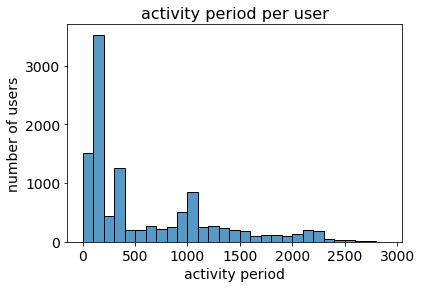

In [ ]:
visualize(data=users_full.activity_period, plot_type='hist', bins=[i for i in range(0,3000,100)],
          xlabel='activity period', ylabel='number of users', title='activity period per user')
plt.show()

expanding the number of bins

#### 1.3.1.2 Average
we're going to add the average monthly number of tweets per user to the entire dataset:

In [ ]:
users_full['tw_monthly_avg'] = users_full['tweets']/users_full['activity_period']

In [ ]:
users_full['tw_monthly_avg'].describe()

count    11487.000000
mean         1.347994
std          2.861275
min          0.000730
25%          0.272233
50%          0.706294
75%          1.346290
max        107.366667
Name: tw_monthly_avg, dtype: float64

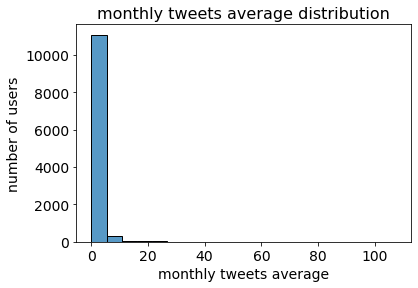

In [ ]:
visualize(data=users_full.tw_monthly_avg, plot_type='hist', bins=20,
          xlabel='monthly tweets average', ylabel='number of users', title='monthly tweets average distribution')
plt.show()

In [ ]:
len(users_full[users_full['tw_monthly_avg'] > 30])

17

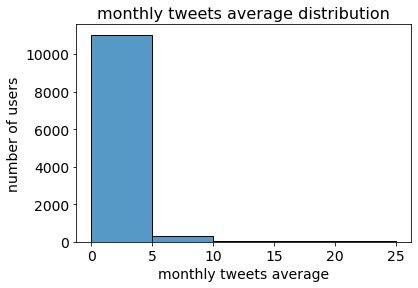

In [ ]:
visualize(data=users_full.tw_monthly_avg, plot_type='hist', bins=[i for i in range(0,30,5)],
          xlabel='monthly tweets average', ylabel='number of users', title='monthly tweets average distribution')
plt.show()

most of users stay between 5 tweets per month

#### 1.3.1.3 Correlation and plots

##### correlation between tweets and activity period

In [ ]:
users_full['tweets'].corr(users_full['activity_period'])

0.6331555701945586

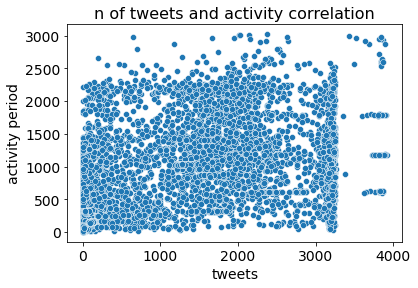

In [ ]:
visualize(x=users_full['tweets'], y=users_full['activity_period'], plot_type='scatter',
          xlabel='tweets', ylabel='activity period', title='n of tweets and activity correlation')
plt.show()

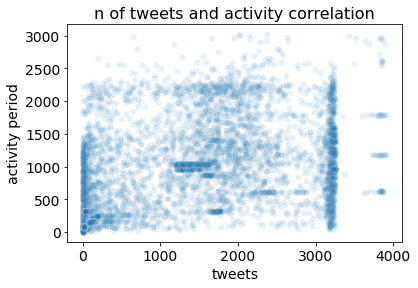

In [ ]:
visualize(x=users_full['tweets'], y=users_full['activity_period'], plot_type='scatter',
          xlabel='tweets', ylabel='activity period', title='n of tweets and activity correlation', alpha=0.1)
plt.show()

it seems someway correlated

##### correlation between statuses count and activity period

In [ ]:
users_full['statuses_count'].corr(users_full['activity_period'])

0.39449693381695145

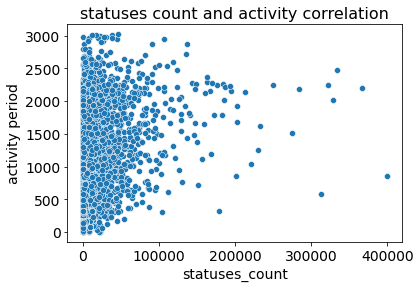

In [ ]:
visualize(x=users_full['statuses_count'], y=users_full['activity_period'], plot_type='scatter',
          xlabel='statuses_count', ylabel='activity period', title='statuses count and activity correlation')
plt.show()

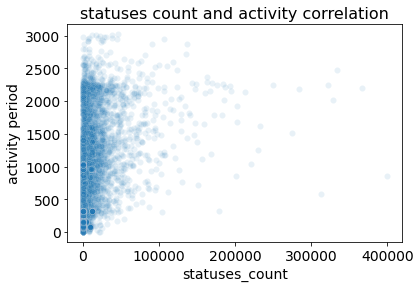

In [ ]:
visualize(x=users_full['statuses_count'], y=users_full['activity_period'], plot_type='scatter',
          xlabel='statuses_count', ylabel='activity period', title='statuses count and activity correlation', alpha=0.1)
plt.show()

##### correlation between favorites and activity period

In [ ]:
users_full['favorites'].corr(users_full['activity_period'])

0.05693057641780498

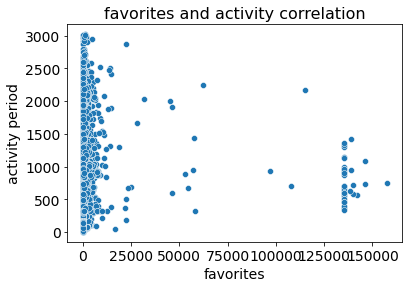

In [ ]:
visualize(x=users_full['favorites'], y=users_full['activity_period'], plot_type='scatter',
          xlabel='favorites', ylabel='activity period', title='favorites and activity correlation')
plt.show()

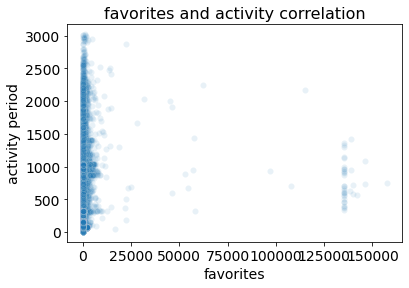

In [ ]:
visualize(x=users_full['favorites'], y=users_full['activity_period'], plot_type='scatter',
          xlabel='favorites', ylabel='activity period', title='favorites and activity correlation', alpha=0.1)
plt.show()

##### correlation between retweets and activity period

In [ ]:
users_full['retweets'].corr(users_full['activity_period'])

0.10127019715158478

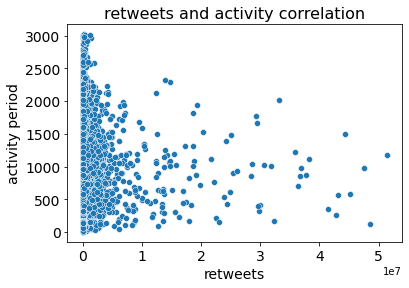

In [ ]:
visualize(x=users_full['retweets'], y=users_full['activity_period'], plot_type='scatter',
          xlabel='retweets', ylabel='activity period', title='retweets and activity correlation')
plt.show()

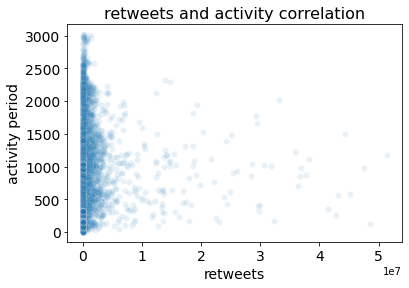

In [ ]:
visualize(x=users_full['retweets'], y=users_full['activity_period'], plot_type='scatter',
          xlabel='retweets', ylabel='activity period', title='retweets and activity correlation', alpha=0.1)
plt.show()

##### Replies
Since statuses_count contains just tweets and retweets number, while in tweets' dataset we also had replies (tweets is the number of tweets+retweets+replies), we'll take the replies number as follow:

In [ ]:
users_full['replies'] = users_full['tweets'] - users_full['statuses_count']

In [ ]:
users_full.replies.describe()

count     11487.000000
mean      -5077.743423
std       17890.178170
min     -396954.000000
25%       -2191.000000
50%           0.000000
75%          48.000000
max        1922.000000
Name: replies, dtype: float64

In [ ]:
len(users_full[users_full['tweets']>users_full['statuses_count']]), len(users_full[users_full['tweets']<users_full['statuses_count']]) 

(4224, 4676)

as we can see, the information do not seem to match. We cannot really tell how many replies there are per user.

In [ ]:
del users_full['replies']

##### Ratio  correlations
Let's see the correlation in those non-zero ratio values. We are considering the avg tweets' ratio per user

In [ ]:
avg_tweets_ratios = pp_tweets.groupby("user_id").ratio.mean()

In [ ]:
len(avg_tweets_ratios), len(users_full)

(11504, 11487)

In [ ]:
users_full = users_full.merge(avg_tweets_ratios, left_index=True, right_index=True)

In [ ]:
users_full.ratio.isna().value_counts()

False    8457
True     3030
Name: ratio, dtype: int64

In [ ]:
users_full.rename(columns={"ratio": "avg_tweets_ratio"}, inplace=True)

In [ ]:
non_nan_ratios = users_full[users_full['avg_tweets_ratio'].isna()==False]

In [ ]:
del non_nan_ratios['lang']
del non_nan_ratios['bot']
del non_nan_ratios['sign_up_date']
del non_nan_ratios['last_activity']

In [ ]:
for feature in non_nan_ratios.keys():
  print('correlation between avg_tweets_ratio and {}: {}'.format(feature, non_nan_ratios.avg_tweets_ratio.corr(non_nan_ratios[feature])))

correlation between avg_tweets_ratio and statuses_count: -0.0742807659169524
correlation between avg_tweets_ratio and st_per_day: -0.07339172837828613
correlation between avg_tweets_ratio and tweets: -0.19906963280877712
correlation between avg_tweets_ratio and favorites: 0.2838983874788529
correlation between avg_tweets_ratio and retweets: -0.038422501398013065
correlation between avg_tweets_ratio and fav_std: 0.30560185181574034
correlation between avg_tweets_ratio and rtw_std: 0.13752828065955694
correlation between avg_tweets_ratio and fav_max: 0.3122674836650581
correlation between avg_tweets_ratio and rtw_max: -0.039065670067714754
correlation between avg_tweets_ratio and fav_mean: 0.26933518663110034
correlation between avg_tweets_ratio and rtw_mean: 0.25751553841393066
correlation between avg_tweets_ratio and retw_over_fav: 0.0028489560217538506
correlation between avg_tweets_ratio and tw_over_retw: -0.08215473505931752
correlation between avg_tweets_ratio and tw_over_fav: -0.0

as we can see there is no correlation to any of these features. The more correlated ones are fav_mean and rtw_mean which are the avg favorite and retweet per user. 

Note that avg_twets_ratio takes the mean of the ratios between retweet and favorite of each tweet per user.

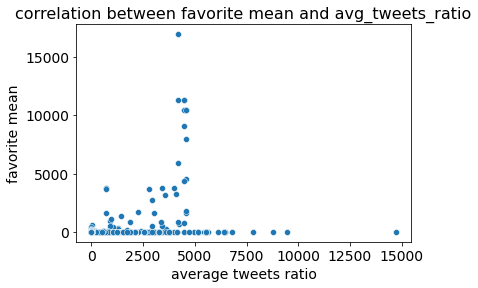

In [ ]:
visualize(x=non_nan_ratios.avg_tweets_ratio, y=non_nan_ratios.fav_mean, plot_type='scatter',
          xlabel='average tweets ratio', ylabel='favorite mean', title='correlation between favorite mean and avg_tweets_ratio')
plt.show()

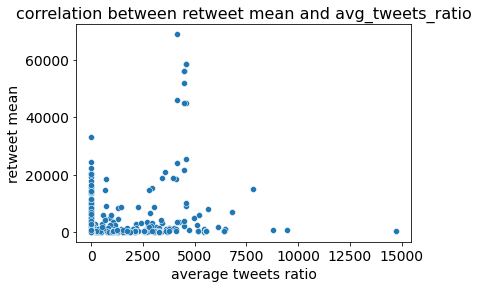

In [ ]:
visualize(x=non_nan_ratios.avg_tweets_ratio, y=non_nan_ratios.rtw_mean, plot_type='scatter',
          xlabel='average tweets ratio', ylabel='retweet mean', title='correlation between retweet mean and avg_tweets_ratio')
plt.show()

### 1.3.2 Tweets in the first month by user

since we lost some users during the process, we'll merge tweets once again, adding the user sign up date

In [ ]:
pp_tweets = pp_tweets.merge(users_full.sign_up_date, left_on='user_id', right_index=True)

In [ ]:
pp_tweets.keys()

Index(['user_id', 'tweet_date', 'retweet_count', 'favorite_count',
       'num_hashtags', 'num_urls', 'num_mentions', 'text', 'text_length',
       'ratio', 'sign_up_date'],
      dtype='object')

In [ ]:
first_month = pp_tweets[pp_tweets.tweet_date <= pp_tweets.sign_up_date + pd.offsets.DateOffset(days=30)].groupby(['user_id'])['user_id'].count().reset_index(name='month1_tweets')

In [ ]:
users_full = users_full.merge(first_month, on='user_id', how='left')

In [ ]:
users_full.month1_tweets.fillna(0, inplace=True)

In [ ]:
print("Max tweets in the first month of user activity: ", first_month.month1_tweets.max())
print("Mean of tweets in the first month of user activity: ", round(first_month.month1_tweets.mean(), 3))

Max tweets in the first month of user activity:  3221
Mean of tweets in the first month of user activity:  20.231


Let's see the comparison between bots and legit users:

In [ ]:
print("Max tweets in the first month made by non-bot users: ", (users_full[users_full.bot==0]).month1_tweets.max())
print("Max tweets in the first month made by bots: ", (users_full[users_full.bot==1]).month1_tweets.max())

Max tweets in the first month made by non-bot users:  3221.0
Max tweets in the first month made by bots:  456.0


This is quite strange, as one would expect the opposite situation. However, since in the Tweets database are counted also retweets, these numbers can not be considered impossible.

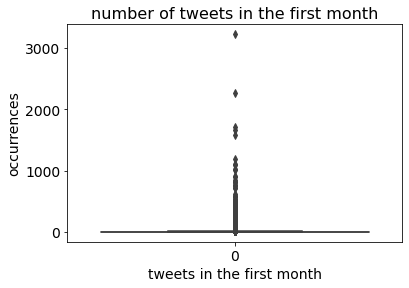

In [ ]:
visualize(data=users_full.month1_tweets, plot_type='boxplot',
          xlabel='tweets in the first month', ylabel='occurrences', title='number of tweets in the first month')
plt.show()

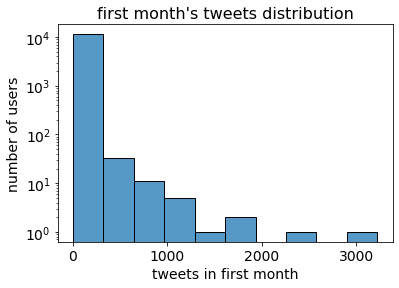

In [ ]:
visualize(data=users_full.month1_tweets, plot_type='hist', bins=10,
          xlabel='tweets in first month', ylabel='number of users', title='first month\'s tweets distribution')
plt.yscale('log')
plt.show()

The distribution is what one can expect, i.e. descreasing

In [ ]:
users_full.month1_tweets.corr(users_full.tw_monthly_avg)

0.6079464028206697

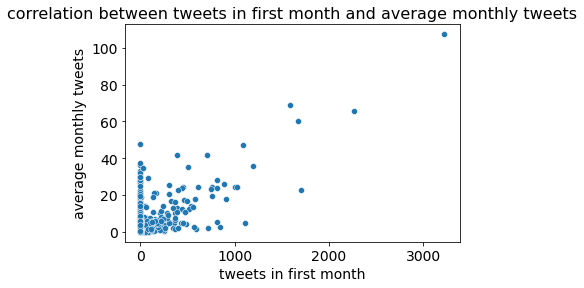

In [ ]:
visualize(x=users_full.month1_tweets, y=users_full.tw_monthly_avg, plot_type='scatter',
          xlabel='tweets in first month', ylabel='average monthly tweets', title='correlation between tweets in first month and average monthly tweets')
plt.show()

it makes sense to them to be correlated

### 1.3.3 Checkpoint

In [ ]:
# save
#users_full.to_csv(basepath+"/users_full_1.3.3.csv") 

In [ ]:
#load
users_full = pd.read_csv(basepath + '/users_full_1.3.3.csv', lineterminator='\n', index_col=0, parse_dates=['sign_up_date'])

In [ ]:
# all the users' metrics so far
users_full.keys()

Index(['user_id', 'lang', 'bot', 'sign_up_date', 'statuses_count',
       'st_per_day', 'tweets', 'favorites', 'retweets', 'fav_std', 'rtw_std',
       'fav_max', 'rtw_max', 'fav_mean', 'rtw_mean', 'retw_over_fav',
       'tw_over_retw', 'tw_over_fav', 'tw_afternoon', 'tw_evening',
       'tw_morning', 'tw_night', 'tw_2012', 'tw_2013', 'tw_2014', 'tw_2015',
       'tw_2016', 'tw_2017', 'tw_2018', 'tw_2019', 'tw_2020', 'avg_schar',
       'last_activity', 'activity_period', 'tw_monthly_avg',
       'avg_tweets_ratio', 'month1_tweets'],
      dtype='object')

### 1.1.4 Entropy

In [ ]:
### ATTENZIONE STO CARICANDO SOLO le  COLONNE che mi servono!
tweets_per_entropy = pd.read_csv(basepath + '/pp_tweets_checkpoint_1.2.4.csv', usecols=[
       'user_id', 'retweet_count', 'favorite_count','created_at',
       'num_hashtags', 'num_urls', 'num_mentions'],
       lineterminator='\n', index_col='user_id', parse_dates=['created_at'])

In [ ]:
tweets_per_entropy.rename(columns={"created_at": "tweet_date"}, inplace=True)

In [ ]:
tweets_per_entropy.keys()

Index(['tweet_date', 'retweet_count', 'favorite_count', 'num_hashtags',
       'num_urls', 'num_mentions'],
      dtype='object')

In [ ]:
users_agg_max = tweets_per_entropy.groupby("user_id").max()

In [ ]:
users_agg_max.keys()

Index(['tweet_date', 'retweet_count', 'favorite_count', 'num_hashtags',
       'num_urls', 'num_mentions'],
      dtype='object')

In [ ]:
from scipy.stats import entropy

In [ ]:
sample_user = next(iter(tweets_per_entropy.groupby("user_id")))

let's see how it works on a single user

In [ ]:
sample_user[1]

,tweet_date,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions
user_id,,,,,,
678033,2020-03-26 02:22:03,0.0,0.0,0.0,0.0,1.0
678033,2020-03-26 02:28:11,21.0,34.0,2.0,0.0,0.0
678033,2020-03-26 02:29:25,0.0,0.0,0.0,0.0,2.0
678033,2020-03-26 02:30:21,6.0,12.0,0.0,0.0,0.0
678033,2020-03-26 02:32:17,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
678033,2020-04-26 00:54:55,0.0,0.0,0.0,1.0,2.0
678033,2020-04-26 05:55:24,0.0,2.0,0.0,0.0,1.0
678033,2020-04-26 11:43:57,0.0,0.0,0.0,0.0,2.0


In [ ]:
# a new interesting metric inspired by the entropy
# frequency of tweets [Hz] := 1/(time diff of 2 consecutive tweets in seconds)
tweet_interval = sample_user[1].tweet_date.sort_values().diff().dt.seconds
print("interval max: ", tweet_interval.max())
print("interval min: ", tweet_interval.min())
print("interval mean: ", tweet_interval.mean())
print("interval entropy: ", entropy(tweet_interval.dropna(),base=2))

interval max:  77689.0
interval min:  0.0
interval mean:  4419.854491775622
interval entropy:  9.353448664875106


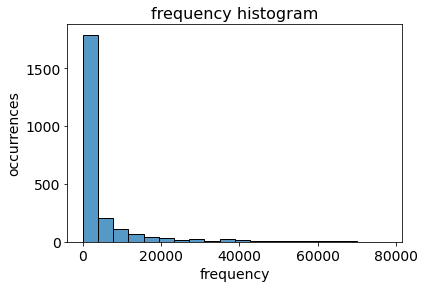

In [ ]:
visualize(data=tweet_interval, plot_type='hist', bins=20,
          xlabel='frequency', ylabel='occurrences', title='frequency histogram')
plt.show()

In [ ]:
def interval_metrics(row_tweet_date):
  tweet_interval = row_tweet_date.sort_values().diff().dt.seconds
  return tweet_interval.min(),tweet_interval.mean(),tweet_interval.max(),entropy(np.histogram(tweet_interval.dropna())[0],base=2)

In [ ]:
interval_metrics_df = tweets_per_entropy.groupby("user_id").tweet_date.agg(interval_metrics)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [ ]:
interval_metrics_df = pd.DataFrame(np.vstack(interval_metrics_df.values)).set_index(interval_metrics_df.index).rename(columns={0:"frequency_min",1:"frequency_mean",2:"frequency_max",3:"frequency_entropy"})

In [ ]:
users_full = pd.merge(users_full, interval_metrics_df, left_index=True, right_index=True)

Let's look againa at a single user example

In [ ]:
subset = ['retweet_count', 'favorite_count', 'num_hashtags',
       'num_urls', 'num_mentions']

for key in subset:
  print(entropy(np.histogram(sample_user[1][key])[0],base=2))

# these variables are continuous/ non limited range vars, so the entropy must be defined by definition of classes.
# here we use the histogram function to create 10 equally spaced classes for each property
# the number of  classes has a big impact on entropy, and it's choice is not obvious

0.07821671305267755
0.1991074225641135
1.1408174417297678
0.9688600223069095
1.8265755418983673


now let's do it for the whole dataset:

In [ ]:
users_entropies = tweets_per_entropy.groupby("user_id")[subset].agg(lambda x: entropy(x,base=2))

/usr/local/lib/python3.7/dist-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [ ]:
users_entropies.rename(columns={k:"entropy_"+k for k in subset},inplace = True)

In [ ]:
users_full = pd.merge(users_full, users_entropies, left_index=True, right_index=True)

In [ ]:
users_full.keys()

Index(['lang', 'bot', 'sign_up_date', 'statuses_count', 'st_per_day', 'tweets',
       'favorites', 'retweets', 'fav_std', 'rtw_std', 'fav_max', 'rtw_max',
       'fav_mean', 'rtw_mean', 'retw_over_fav', 'tw_over_retw', 'tw_over_fav',
       'tw_afternoon', 'tw_evening', 'tw_morning', 'tw_night', 'tw_2012',
       'tw_2013', 'tw_2014', 'tw_2015', 'tw_2016', 'tw_2017', 'tw_2018',
       'tw_2019', 'tw_2020', 'avg_schar', 'last_activity', 'activity_period',
       'tw_monthly_avg', 'avg_tweets_ratio', 'month1_tweets', 'frequency_min',
       'frequency_mean', 'frequency_max', 'frequency_entropy',
       'entropy_retweet_count', 'entropy_favorite_count',
       'entropy_num_hashtags', 'entropy_num_urls', 'entropy_num_mentions'],
      dtype='object')

In [ ]:
users_full['tot_entropy'] = users_full[['frequency_entropy',
       'entropy_retweet_count', 'entropy_favorite_count',
       'entropy_num_hashtags', 'entropy_num_urls', 'entropy_num_mentions']].sum(axis=1)

### 1.1.5 Outliers visualization and NaN handling

In [ ]:
users_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11487 entries, 2353593986 to 933183398
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   lang                    11487 non-null  object        
 1   bot                     11487 non-null  int64         
 2   sign_up_date            11487 non-null  datetime64[ns]
 3   statuses_count          11487 non-null  float64       
 4   st_per_day              11088 non-null  float64       
 5   tweets                  11487 non-null  int64         
 6   favorites               11487 non-null  float64       
 7   retweets                11487 non-null  float64       
 8   fav_std                 11370 non-null  float64       
 9   rtw_std                 11370 non-null  float64       
 10  fav_max                 11487 non-null  float64       
 11  rtw_max                 11487 non-null  float64       
 12  fav_mean                11487 non

since we noticed that st_per_day does have some nan values, caused by the fact we haven't repaired them in time, we're going to recalculate st_per_day using the more appropriate time interval, i.e. activity_period.

In [ ]:
users_full['st_per_day'] = users_full.statuses_count/users_full.activity_period

In [ ]:
users_full.replace([np.inf, -np.inf], np.nan, inplace=True)

we're going to replace all the ratio's nans with -1 value because we do not want to mix the 0/0 ratio with the n/0 ratio.

the std nans are going to be replaced with 0 since the nan values are due to the "population standard deviation" which is normalized by n-1, and its result is undefined (inf) for sets of 1 single observation.

finally the entropy nans (except those derived by ratio/freq) are going to be replaced by 0, because are due to the impossibility to calculate entropy on an empty popu


In [ ]:
zeros = ['fav_std', 'rtw_std', 'entropy_retweet_count', 'entropy_favorite_count', 
         'entropy_num_hashtags', 'entropy_num_urls', 'entropy_num_mentions']

minus_ones = ['retw_over_fav', 'avg_tweets_ratio', 'tw_over_retw', 'tw_over_fav',
              'frequency_min', 'frequency_mean', 'frequency_max', 'frequency_entropy']

users_full[zeros] = users_full[zeros].fillna(0)
users_full[minus_ones] = users_full[minus_ones].fillna(-1)

In [ ]:
users_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11487 entries, 2353593986 to 933183398
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   lang                    11487 non-null  object        
 1   bot                     11487 non-null  int64         
 2   sign_up_date            11487 non-null  datetime64[ns]
 3   statuses_count          11487 non-null  float64       
 4   st_per_day              11487 non-null  float64       
 5   tweets                  11487 non-null  int64         
 6   favorites               11487 non-null  float64       
 7   retweets                11487 non-null  float64       
 8   fav_std                 11487 non-null  float64       
 9   rtw_std                 11487 non-null  float64       
 10  fav_max                 11487 non-null  float64       
 11  rtw_max                 11487 non-null  float64       
 12  fav_mean                11487 non

### 1.9.9 Users Dataset Last Checkpoint

In [ ]:
users_full = users_full.rename(columns={
      'tweets':'tot_tweets',
      'favorites':'tot_favorites',
      'retweets':'tot_retweets',
    })

In [ ]:
users_full.keys()

Index(['lang', 'bot', 'sign_up_date', 'statuses_count', 'st_per_day',
       'tot_tweets', 'tot_favorites', 'tot_retweets', 'fav_std', 'rtw_std',
       'fav_max', 'rtw_max', 'fav_mean', 'rtw_mean', 'retw_over_fav',
       'tw_over_retw', 'tw_over_fav', 'tw_afternoon', 'tw_evening',
       'tw_morning', 'tw_night', 'tw_2012', 'tw_2013', 'tw_2014', 'tw_2015',
       'tw_2016', 'tw_2017', 'tw_2018', 'tw_2019', 'tw_2020', 'avg_schar',
       'last_activity', 'activity_period', 'tw_monthly_avg',
       'avg_tweets_ratio', 'month1_tweets', 'frequency_min', 'frequency_mean',
       'frequency_max', 'frequency_entropy', 'entropy_retweet_count',
       'entropy_favorite_count', 'entropy_num_hashtags', 'entropy_num_urls',
       'entropy_num_mentions', 'tot_entropy'],
      dtype='object')

In [ ]:
#users_full.to_csv(basepath+"/users_full_1.9.9.csv")

In [ ]:
users_full = pd.read_csv(basepath + '/users_full_1.9.9.csv', lineterminator='\n', index_col=0, parse_dates=['sign_up_date'])

In [ ]:
users_full.head()

,lang,bot,sign_up_date,statuses_count,st_per_day,tot_tweets,tot_favorites,tot_retweets,fav_std,rtw_std,...,frequency_min,frequency_mean,frequency_max,frequency_entropy,entropy_retweet_count,entropy_favorite_count,entropy_num_hashtags,entropy_num_urls,entropy_num_mentions,tot_entropy
user_id,,,,,,,,,,,,,,,,,,,,,
2353593986,en,1,2019-02-22 18:00:42,76.0,0.472050,118,5.0,4.0,0.202297,0.181739,...,4.0,10689.307692,84623.0,1.266594,2.000000,2.321928,2.815072,0.000000,5.129283,13.532878
2358850842,en,0,2019-02-26 03:02:32,54.0,0.341772,104,6.0,3.0,0.234290,0.168185,...,3.0,10358.776699,82382.0,1.266620,1.584963,2.584963,1.584963,0.000000,5.247928,12.269435
137959629,en,1,2015-04-30 07:09:56,3.0,0.007335,3,0.0,0.0,0.000000,0.000000,...,713.0,32322.000000,63931.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
466124818,it,1,2017-01-18 02:49:18,50.0,0.048497,1249,240.0,1184.0,0.578656,13.987564,...,3.0,11327.483173,85767.0,1.811890,3.100784,7.349273,5.709869,5.000000,2.641604,25.613421
2571493866,en,0,2019-06-18 19:30:21,7085.0,22.210031,3174,205.0,56.0,0.259554,0.145325,...,1.0,3282.573590,15248.0,2.207123,5.615303,7.572163,8.347741,1.584963,10.494934,35.822227
